In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from matplotlib import cm
from pylab import *


import os
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats


piygcols = cm.get_cmap('PiYG_r', 5)    # PiYG

for i in range(piygcols.N):
    rgba = piygcols(i)
    # rgb2hex accepts rgb or rgba
    stradd = matplotlib.colors.rgb2hex(rgba)


In [4]:
coher_cols = ['#276419', '#9ccf64', '#f7f7f7', '#e896c4', '#8e0152'] ##PiYG 5 steps
coher_cols_seq = ['#d8ffff', '#85d9f0', '#2cb0e0', '#0083c6', '#0057a7'] #light blue to blue
pres_cols = ['xkcd:pink', 'xkcd:lavender', 'xkcd:light grey'] #pink = FP, lav = PP, blue = TR
proc_cols = ['#ff8500', '#ffca20', '#ffffe0', '#bf74e7', '#8044da'] #(orange to purple) agg to lat acc
pres_palette = sns.color_palette(pres_cols)
coh_palette = sns.color_palette(coher_cols_seq)
proc_palette = sns.color_palette(proc_cols)


In [5]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

In [6]:
deepcopy(coher_cols)

['#276419', '#9ccf64', '#f7f7f7', '#e896c4', '#8e0152']

In [25]:
filenm = 'agubh2-100m-edit'
xlsxname = filenm+'.xlsx'
savefilesto = '/Volumes/SAF_Data/bar-manuscript_sum22/data-interp/'
mypath = f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{xlsxname}'
allbars = pd.read_excel(mypath, header=0, usecols = 'A:BF') ## change if you add more columns to the raw dataset
eqt = 65 ## time for the bed to equilibrate
active_channels = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_active_channels-ud.npy')

wetted_width = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2WWmaster-ud.npy')

### Add extra ratios to allbars dataframe


In [26]:
allbars['CVFlowDepth'] = allbars['SDFlowDepth']/allbars['MeanFlowDepth']
allbars['CVVelocity'] = allbars['SDVelocity']/allbars['MeanVelocity']
allbars['Skew Abs'] = abs(allbars['Angle Skewness'])


In [27]:
# df.loc[ df[“column_name”] == “some_value”, “column_name”] = “value”
allbars['TempAgg'] = allbars['MedClinoHt']/allbars['MaxClinoHt']
allbars['Skew Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['Skew Abs'] > 1, allbars['Skew Abs'] < 3), 'Skew Binned'] = 1
allbars.loc[allbars['Skew Abs'] < 1, 'Skew Binned'] = 0
allbars.loc[allbars['Skew Abs'] > 3, 'Skew Binned'] = 2

allbars['Co Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['CoherenceVal'] > 2, allbars['CoherenceVal'] <= 3), 'Co Binned'] = 1
allbars.loc[allbars['CoherenceVal'] <= 2, 'Co Binned'] = 0

allbars.loc[allbars['CoherenceVal'] > 3, 'Co Binned'] = 2

In [28]:
allbars['BSR Binned'] = allbars['Basal Surf Relief']
allbars.loc[np.logical_or(allbars['Basal Surf Relief'] > 0.5, allbars['Basal Surf Relief'] < 1), 'BSR Binned'] = 1
allbars.loc[allbars['Basal Surf Relief'] < 0.5, 'BSR Binned'] = 0
allbars.loc[allbars['Basal Surf Relief'] > 1, 'BSR Binned'] = 2

In [29]:
## recalc facies
d50 = 0.00031
# chezy_rough = 18*(np.log10(4*allbars['MedFlowDepth']/d50)) #i think this is log10, else they would've put ln no?

med_mmp =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MeanFacies'] =(1000*(allbars['MeanVelocity']**2))/(1650*((18*(np.log10(4*allbars['MeanFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MedFacies'] =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter

In [30]:
allbars['BinFacMean'] = allbars['MeanFacies']
allbars.loc[allbars['MeanFacies'] < 0.17, 'BinFacMean'] = 'LB'
allbars.loc[allbars['MeanFacies'] > 0.17, 'BinFacMean'] = 'UB'

In [31]:
allbars['BarHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['MaxClino/MaxFD'] = allbars['MaxClinoHt']/allbars['MaxFlowDepth']
allbars['MaxClino/MedFD'] = allbars['MaxClinoHt']/allbars['MedFlowDepth']
allbars['MedClino/MedFD'] = allbars['MedClinoHt']/allbars['MedFlowDepth']

In [32]:
allbars['BFscaling'] = allbars['MaxClinoHt']/1.5
allbars['BL/CL'] = allbars['BarWidth']/allbars['MaxClinoWt']

In [33]:
## Find the proportion of upper bar facies in each bar package

allbars['UBar'] = np.nan
arrayfolder = 'agubh2-100m-mmp'
# init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/JULY142022'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{arrayfolder}'

for root, dirs, files in os.walk(init):
    for file in files:
        arr = np.load(os.path.join(root, file), allow_pickle = True)
        arrnm = file[:-4]
        mmp = arr[:, :, -1] ## the arrays already have the mmp values in them
        tot = np.count_nonzero(~np.isnan(mmp))
        pub = (mmp <= 0.15).sum()/tot
        plb = (mmp > 0.15).sum()/tot
        allbars.loc[allbars['array name']==arrnm, 'UBar'] = pub

### Summary Statistics Table


In [34]:
##–––––––––––––––––––––––––––––– Summary for Preservation——————————————————————————————————##
pres_summary = pd.DataFrame(columns = ['PreservChar'])
variabs = ['BarHeight', 'BarWidth', 'BarAspect', 'ChannelProp', 'Angle Skewness', 
           'Basal Surf Relief', 'Median dzdx', 'MeanClinoICD', 'MeanFlowDepth', 'MeanVelocity', 'MeanShear', 'MeanFacies']
diag_char = ['FP', 'PP', 'TR']
for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['PreservChar'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['PreservChar']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['PreservChar']==char]), 
                                                                             stats.iqr(allbars[var][allbars['PreservChar']==char], nan_policy = 'omit')]])
    pres_summary = pd.concat([pres_summary, tempdf], ignore_index = True)
    
##–––––––––––––––––––––––––––––– Summary for Coherence——————————————————————————————————##
coh_summary = pd.DataFrame(columns = ['CoherenceVal'])
diag_char = [1, 2, 3, 4, 5]
for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['CoherenceVal'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['CoherenceVal']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['CoherenceVal']==char]), 
                                                                             stats.iqr(allbars[var][allbars['CoherenceVal']==char], nan_policy = 'omit')]])
    coh_summary = pd.concat([coh_summary, tempdf], ignore_index = True)

##–––––––––––––––––––––––––––––– Summary for Process ——————————————————————————————————##
proc_summary = pd.DataFrame(columns = ['process interp'])
diag_char = np.unique(allbars['process interp'])

for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['process interp'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['process interp']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['process interp']==char]), 
                                                                             stats.iqr(allbars[var][allbars['process interp']==char], nan_policy = 'omit')]])
    proc_summary = pd.concat([proc_summary, tempdf], ignore_index = True)
summary_table = pd.concat([pres_summary, coh_summary, proc_summary], ignore_index = True)
summary_table.to_csv(f'{savefilesto}{filenm}_summary.csv')

### Trends in Pres/Coh/Process

<AxesSubplot:xlabel='process interp', ylabel='Count'>

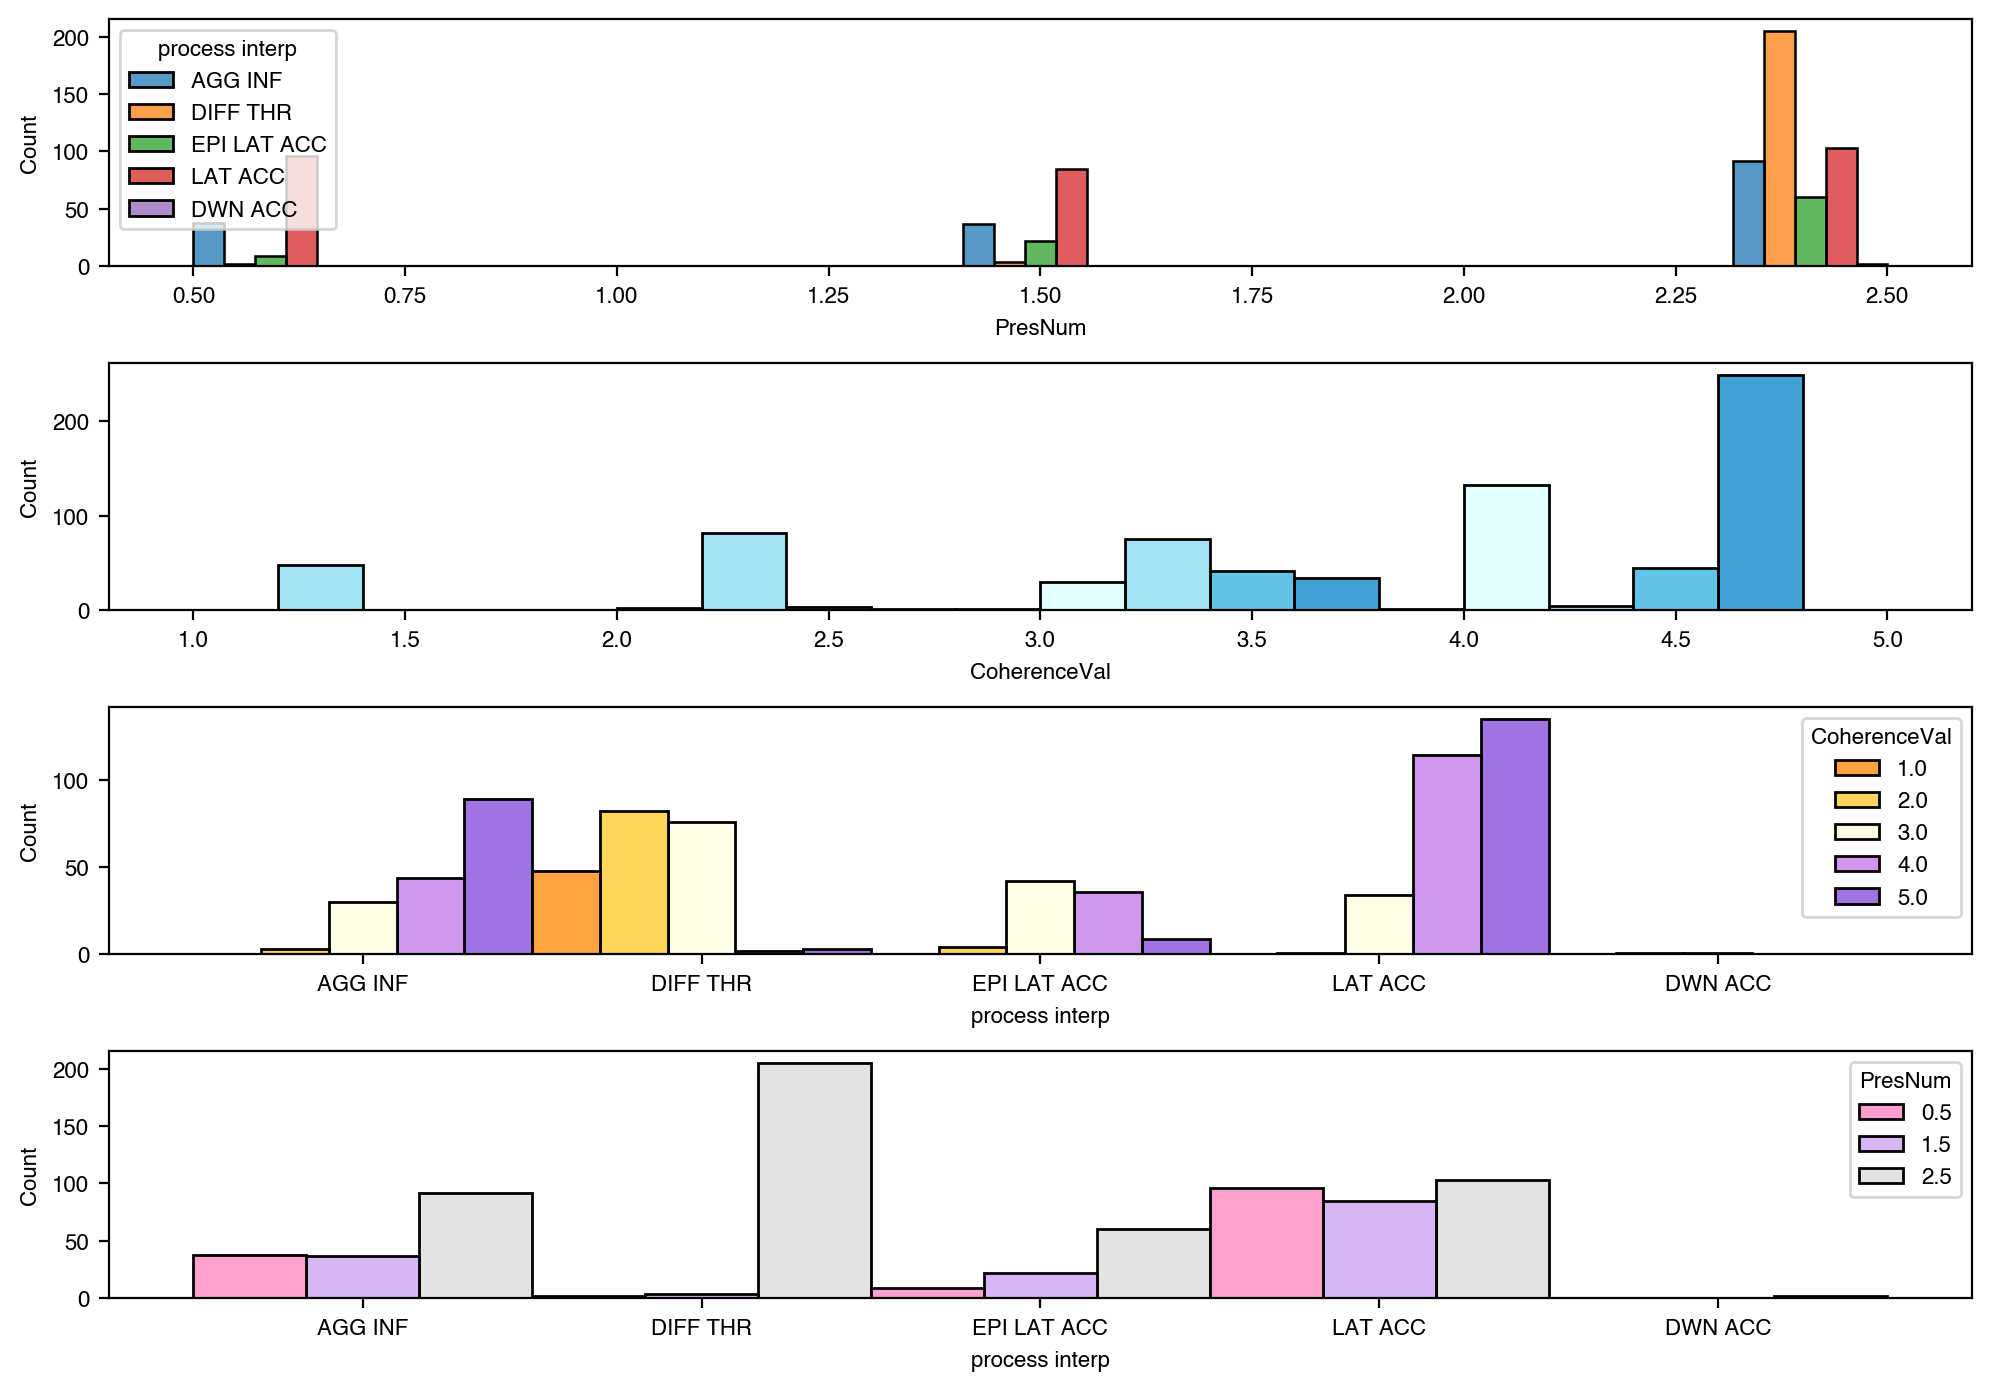

In [35]:
fig, ax = plt.subplots(4, figsize = (10, 7), dpi = 200, tight_layout=True)

#sns.histplot(allbars['PresNum'], bins = [0, 1, 2, 3])#, hue = allbars['process interp'], linewidth = .4, edgecolor = 'k')
sns.histplot(data=allbars, x = 'PresNum', hue = 'process interp', multiple='dodge', ax = ax[0], legend=True)

sns.histplot(data=allbars, x = 'CoherenceVal', hue = 'process interp', multiple='dodge', ax = ax[1], legend = False, palette = coh_palette, binwidth = 1)
sns.histplot(data=allbars, x = 'process interp', hue = 'CoherenceVal', multiple='dodge', ax = ax[2], legend = True, palette = proc_palette)
sns.histplot(data=allbars, x = 'process interp', hue = 'PresNum', multiple='dodge', ax = ax[3], legend = True, palette = pres_palette)
# ax[0].legend(bbox_to_anchor=(1,1))

### Widening/Width trends

##### Trying to make that plot of the channel planform and the abundance of each type of bar in the section, compared to widening rates

In [18]:
## import widening rates
#profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh210km-profile.npy') ## channel profile for each timestep
profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/channel-profile-ud.npy') ## channel profile for each timestep
print(profile_master.shape)
# 0 = ilocs, starts at 0m, every 10m
# 1 = right bank
# 2 = left bank
# 3 = rb displacement (from timestep before)
# 4 = lb displacement (from timestep before)
# 5 = rb widening rate
# 6 = lb widening rate (2 hr intervals)
interval = 2
cropint = 5
pm_10 = deepcopy(profile_master[:, :, ::cropint])
total_wr = ((pm_10[:, 2, 1:]-pm_10[:, 1, 1:])-(pm_10[:, 2, :-1]-pm_10[:, 1, :-1]))/(interval*cropint) ##every 10 hours
total_wr_2h = ((profile_master[:, 2, 1:]-profile_master[:, 1, 1:])-(profile_master[:, 2, :-1]-profile_master[:, 1, :-1]))

(1001, 7, 382)


Width vs Widening Rate <br>
assuming that the entire bed is wet during the entire run

In [19]:
# test = np.transpose(profile_master, (profile_master.shape[2], profile_master.shape[1], profile_master.shape[0]))
byiloc = np.transpose(profile_master, (2, 1, 0)) ## profiles array transposed so every page/sheet is one iloc

find rows where a value = True `allbars[allbars['iloc']==150]`

print headers
`df.columns()`

#### Lollipop width plots

In [20]:
iloc150 = allbars[allbars['iloc']==150]
widen150 = profile_master[:, :, 150]

Text(0, 0.5, 'Widening Rate\n (2hr intervals)')

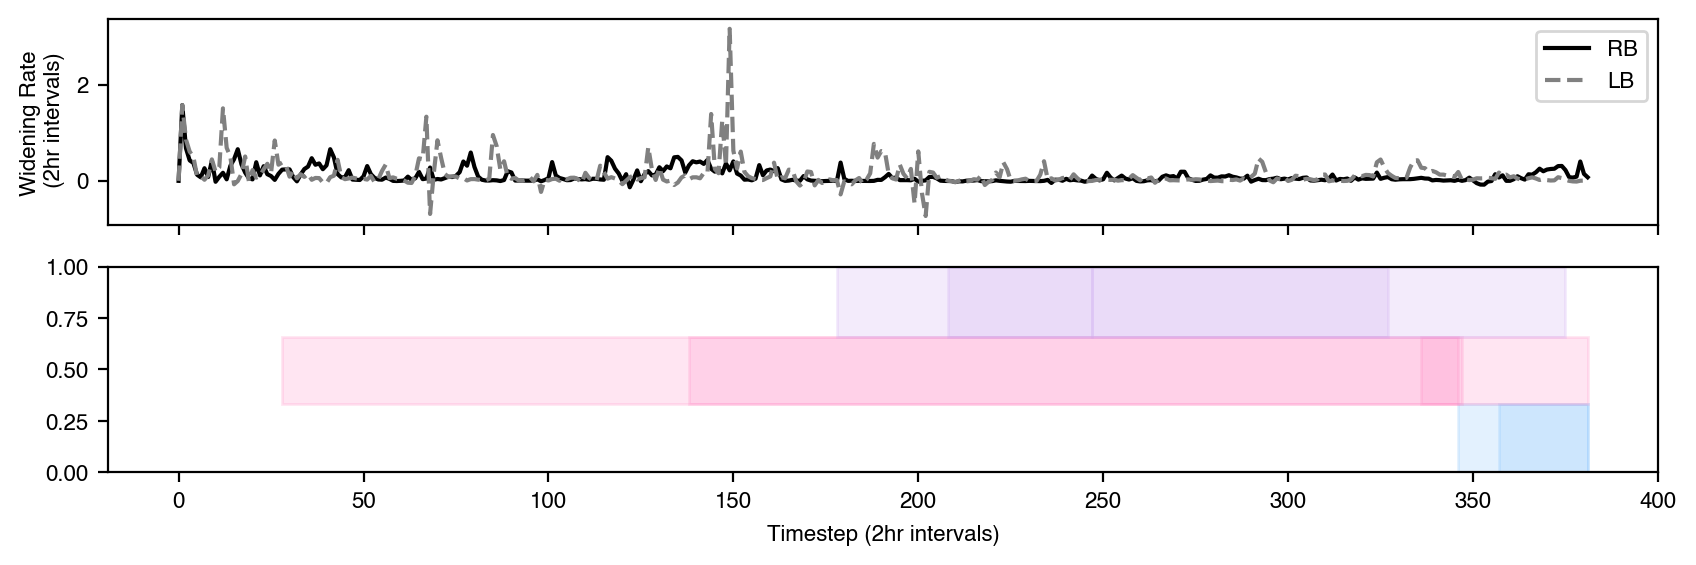

In [21]:
# plt.plot(widen150[:, 0])
fig, ax = plt.subplots(2, figsize = (10, 3), dpi = 200, sharex = True)
ax[0].plot(profile_master[150, 5, :], 'k', label = 'RB') ## this is the indexing to get one row
ax[0].plot(profile_master[150, 6, :], color = 'grey', ls = '--', label = 'LB') 
ax[0].legend()
for i in range (0, len(iloc150)):
    if iloc150.iloc[i]['PreservChar']=='FP':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0, ymax= 0.33, color = 'xkcd:sky blue', alpha = 0.2)
    elif iloc150.iloc[i]['PreservChar']=='PP':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0.33, ymax = 0.66, color = 'xkcd:pink', alpha = 0.2)
    elif iloc150.iloc[i]['PreservChar']=='TR':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0.66, ymax = 1, color = 'xkcd:lavender', alpha = 0.2)
        
ax[1].set_xlabel('Timestep (2hr intervals)')
ax[0].set_ylabel('Widening Rate\n (2hr intervals)')

Text(0.5, 0, 'Start Time')

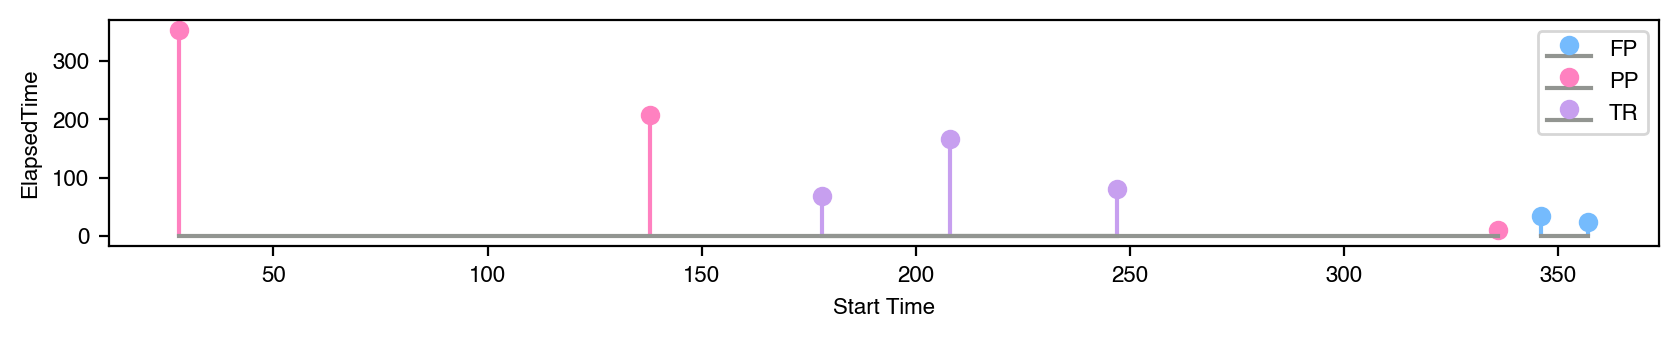

In [20]:
plt.figure(figsize = (10, 1.5), dpi = 200)

mkrfp, stmfp, basefp = plt.stem(iloc150[iloc150['PreservChar']=='FP']['StartTime'], iloc150[iloc150['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = 'xkcd:grey')
plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))

mkrpp, stmpp, basepp = plt.stem(iloc150[iloc150['PreservChar']=='PP']['StartTime'], iloc150[iloc150['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = 'xkcd:grey')
plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))

mkrtr, stmtr, basetr = plt.stem(iloc150[iloc150['PreservChar']=='TR']['StartTime'], iloc150[iloc150['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = 'xkcd:grey')
plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))

plt.legend()
plt.ylabel('ElapsedTime')
plt.xlabel('Start Time')

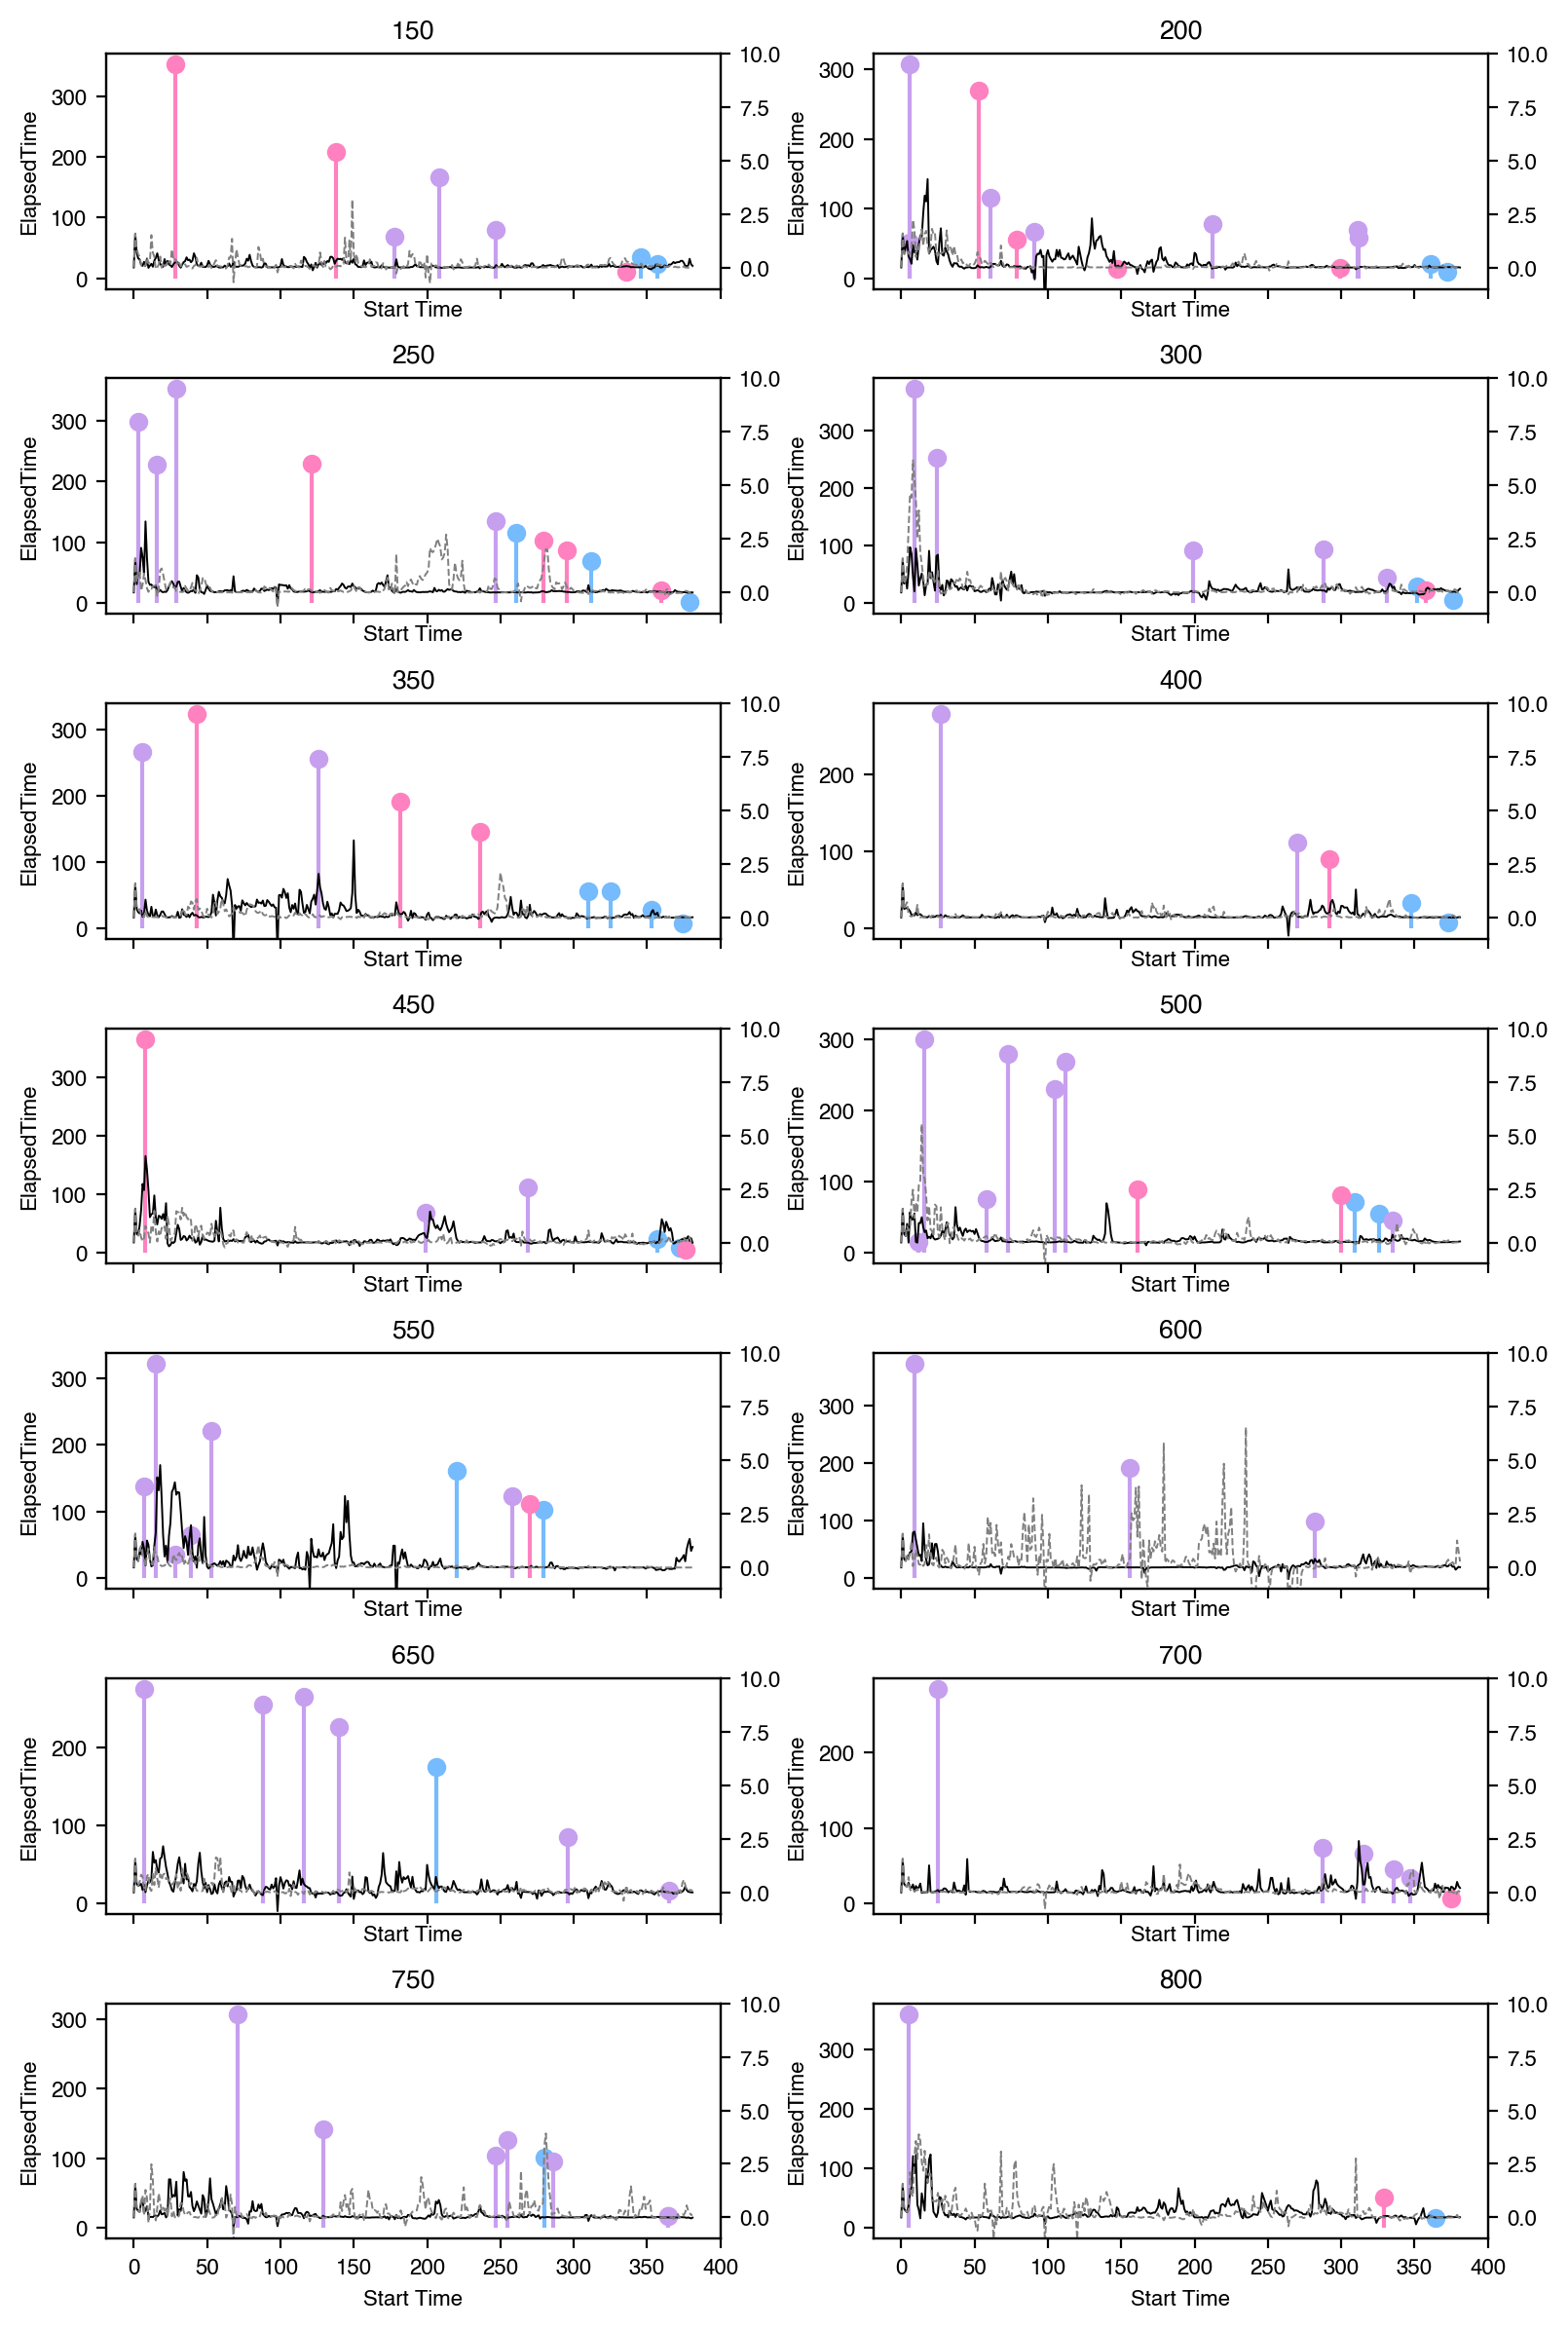

In [235]:
ilocs = np.arange(150, 850, 50)

fig, ax = plt.subplots(len(ilocs)//2, 2, figsize = (8, 12), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.set_ylim(-1, 10)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

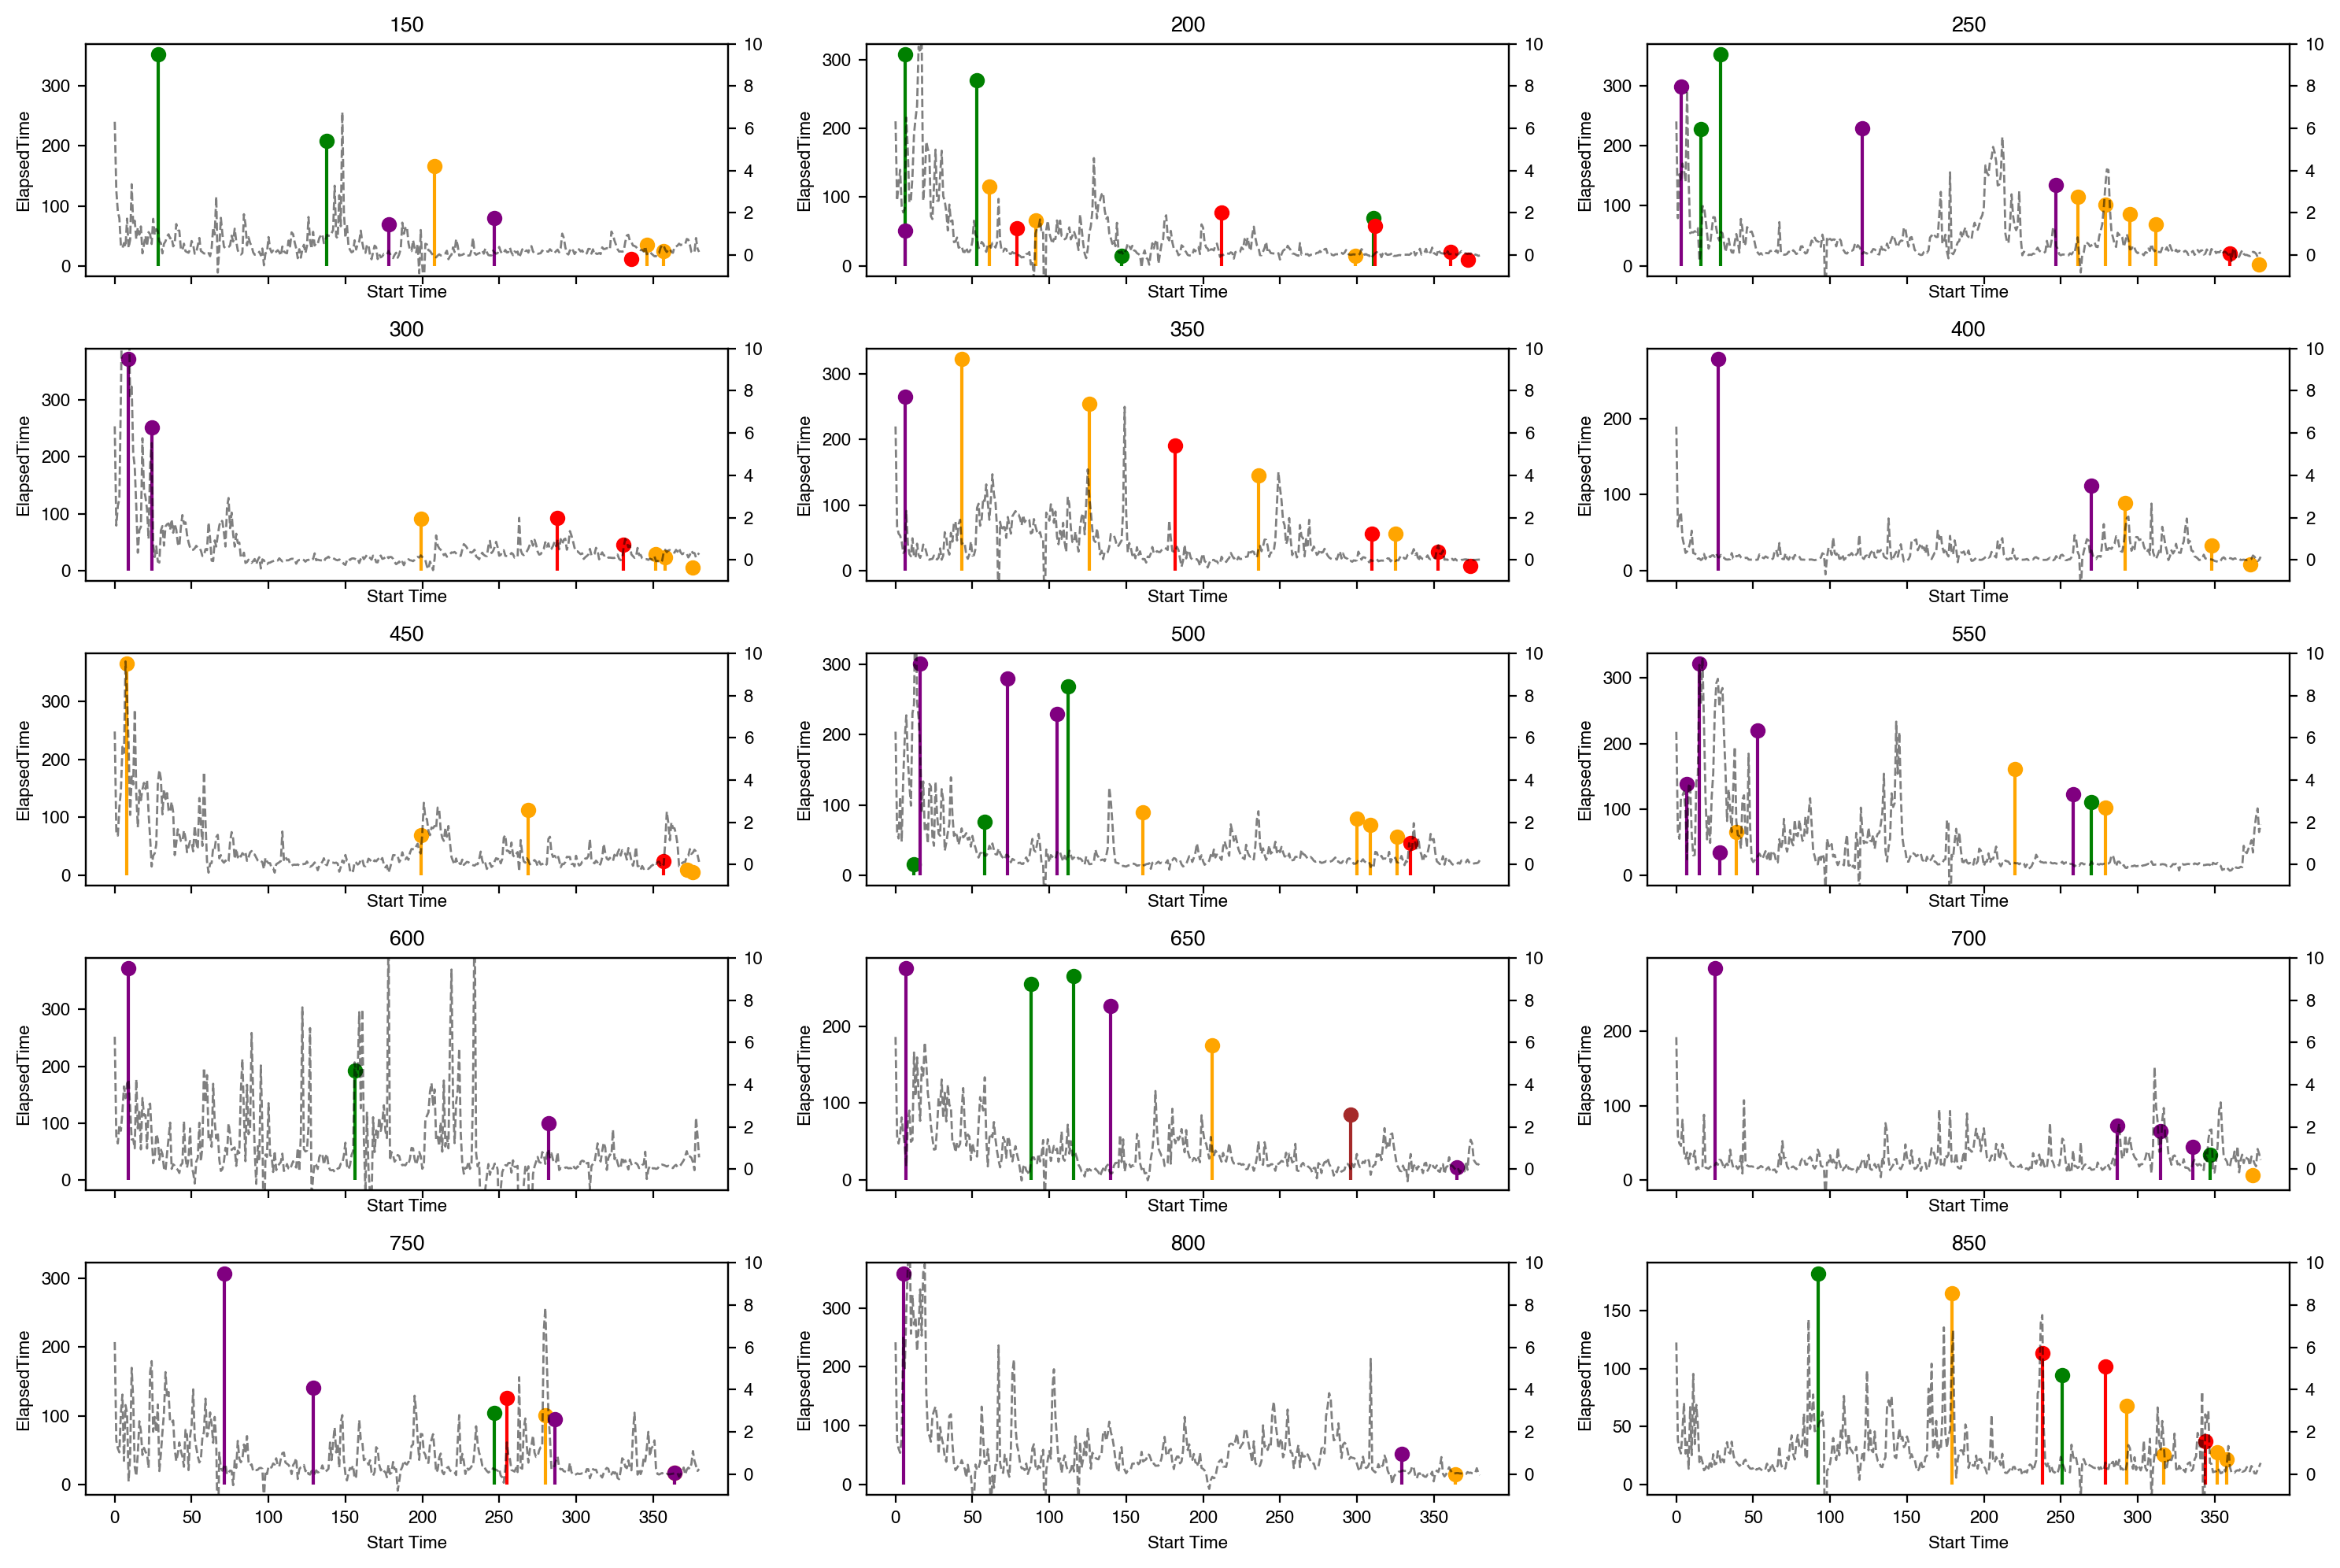

In [34]:
ilocs = np.arange(150, 900, 50)
times = np.arange(total_wr_2h.shape[1])
fig, ax = plt.subplots(len(ilocs)//3, 3, figsize = (15, 10), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    
    ax2 = ax[idx].twinx()
    ax2.plot(times, total_wr_2h[i, :], 'k--', label = 'RB', lw = 1, zorder=0, alpha = .5) ## this is the indexing to get one row

    ax2.set_ylim(-1, 10)
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['process interp']=='LAT INF']['StartTime'], blank[blank['process interp']=='LAT INF']['ElapsedTime'], linefmt = 'blue', label = 'LAI', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['process interp']=='LAT ACC']['StartTime'], blank[blank['process interp']=='LAT ACC']['ElapsedTime'], linefmt = 'orange', label = 'LAC', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['process interp']=='EPI LAT ACC']['StartTime'], blank[blank['process interp']=='EPI LAT ACC']['ElapsedTime'], linefmt = 'green', label = 'ELA', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['process interp']=='AGG INF']['StartTime'], blank[blank['process interp']=='AGG INF']['ElapsedTime'], linefmt = 'red', label = 'AGI', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['process interp']=='DIFF THR']['StartTime'], blank[blank['process interp']=='DIFF THR']['ElapsedTime'], linefmt = 'purple', label = 'DIF', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['process interp']=='DWN ACC']['StartTime'], blank[blank['process interp']=='DWN ACC']['ElapsedTime'], linefmt = 'brown', label = 'DWN', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)

    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

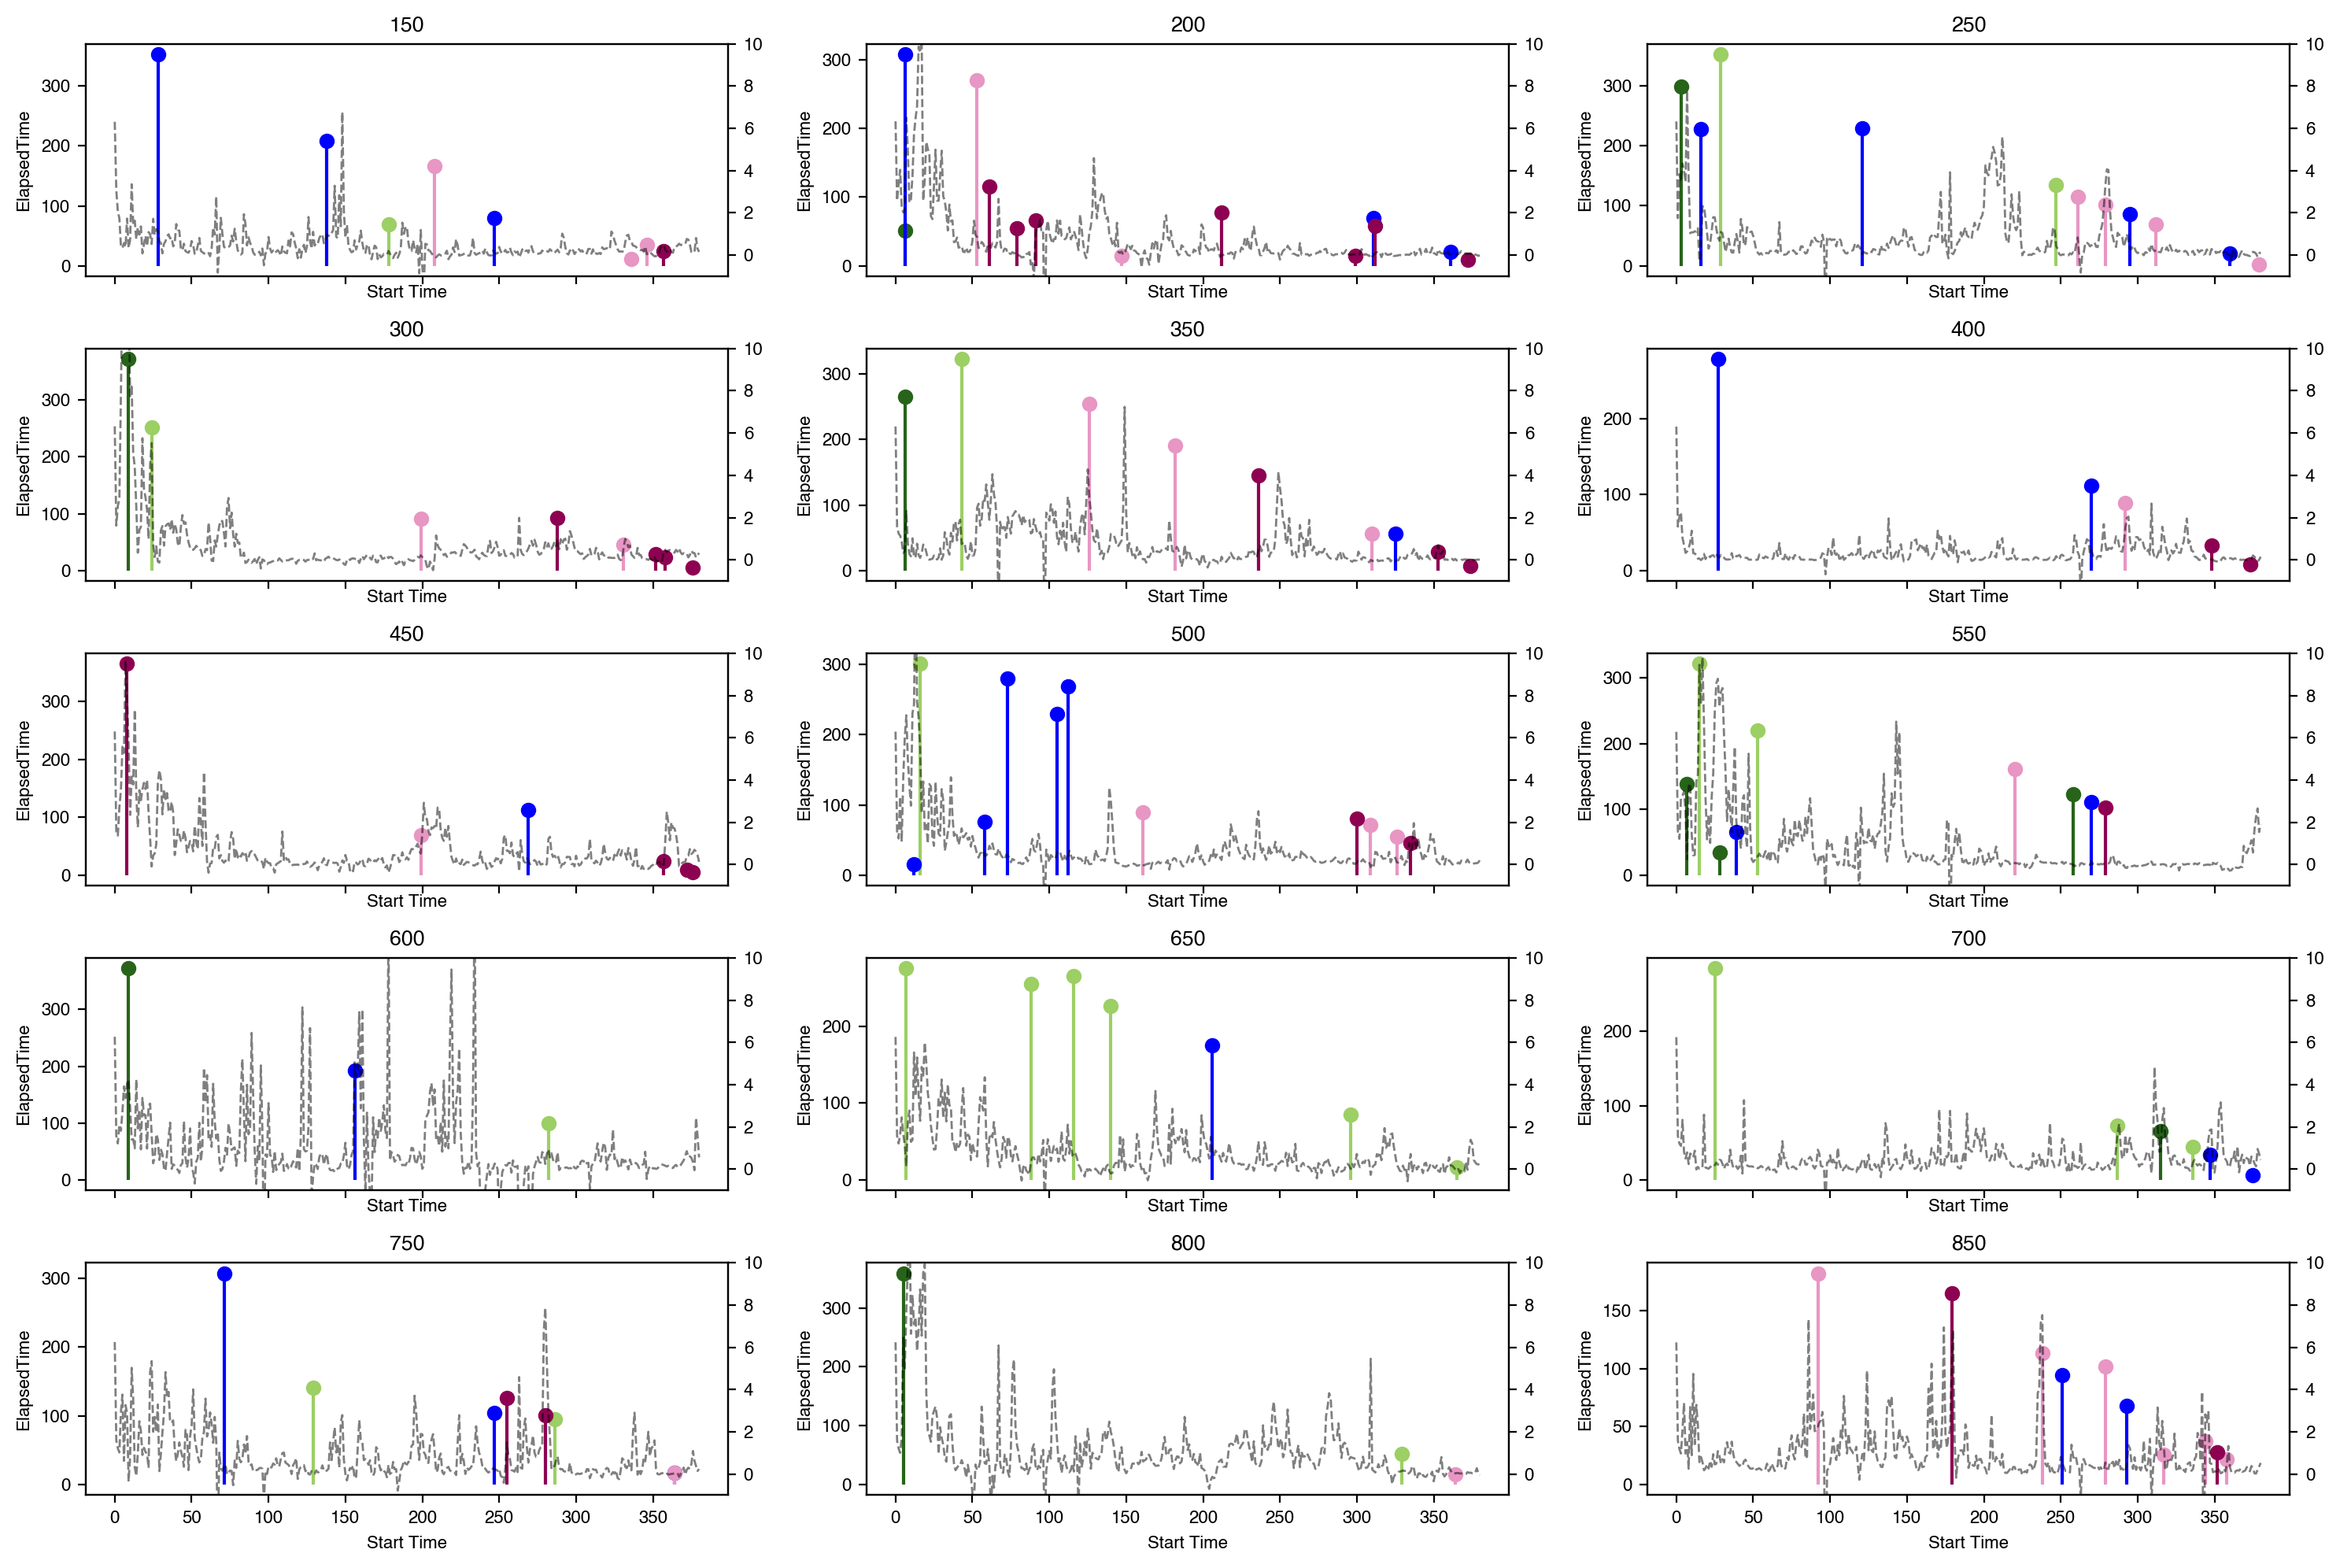

In [35]:
ilocs = np.arange(150, 900, 50)
times = np.arange(total_wr_2h.shape[1])
fig, ax = plt.subplots(len(ilocs)//3, 3, figsize = (15, 10), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    
    ax2 = ax[idx].twinx()
    ax2.plot(times, total_wr_2h[i, :], 'k--', label = 'RB', lw = 1, zorder=0, alpha = .5) ## this is the indexing to get one row

    ax2.set_ylim(-1, 10)
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['CoherenceVal']==1]['StartTime'], blank[blank['CoherenceVal']==1]['ElapsedTime'], linefmt = coher_cols[0], label = 1, basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['CoherenceVal']==2]['StartTime'], blank[blank['CoherenceVal']==2]['ElapsedTime'], linefmt = coher_cols[1], label = 2, basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['CoherenceVal']==3]['StartTime'], blank[blank['CoherenceVal']==3]['ElapsedTime'], linefmt = 'blue', label = 'ELA', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['CoherenceVal']==4]['StartTime'], blank[blank['CoherenceVal']==4]['ElapsedTime'], linefmt = coher_cols[3], label = 'AGI', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['CoherenceVal']==5]['StartTime'], blank[blank['CoherenceVal']==5]['ElapsedTime'], linefmt = coher_cols[4], label = 'DIF', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)
    
    ax[idx].set_title(i)

    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

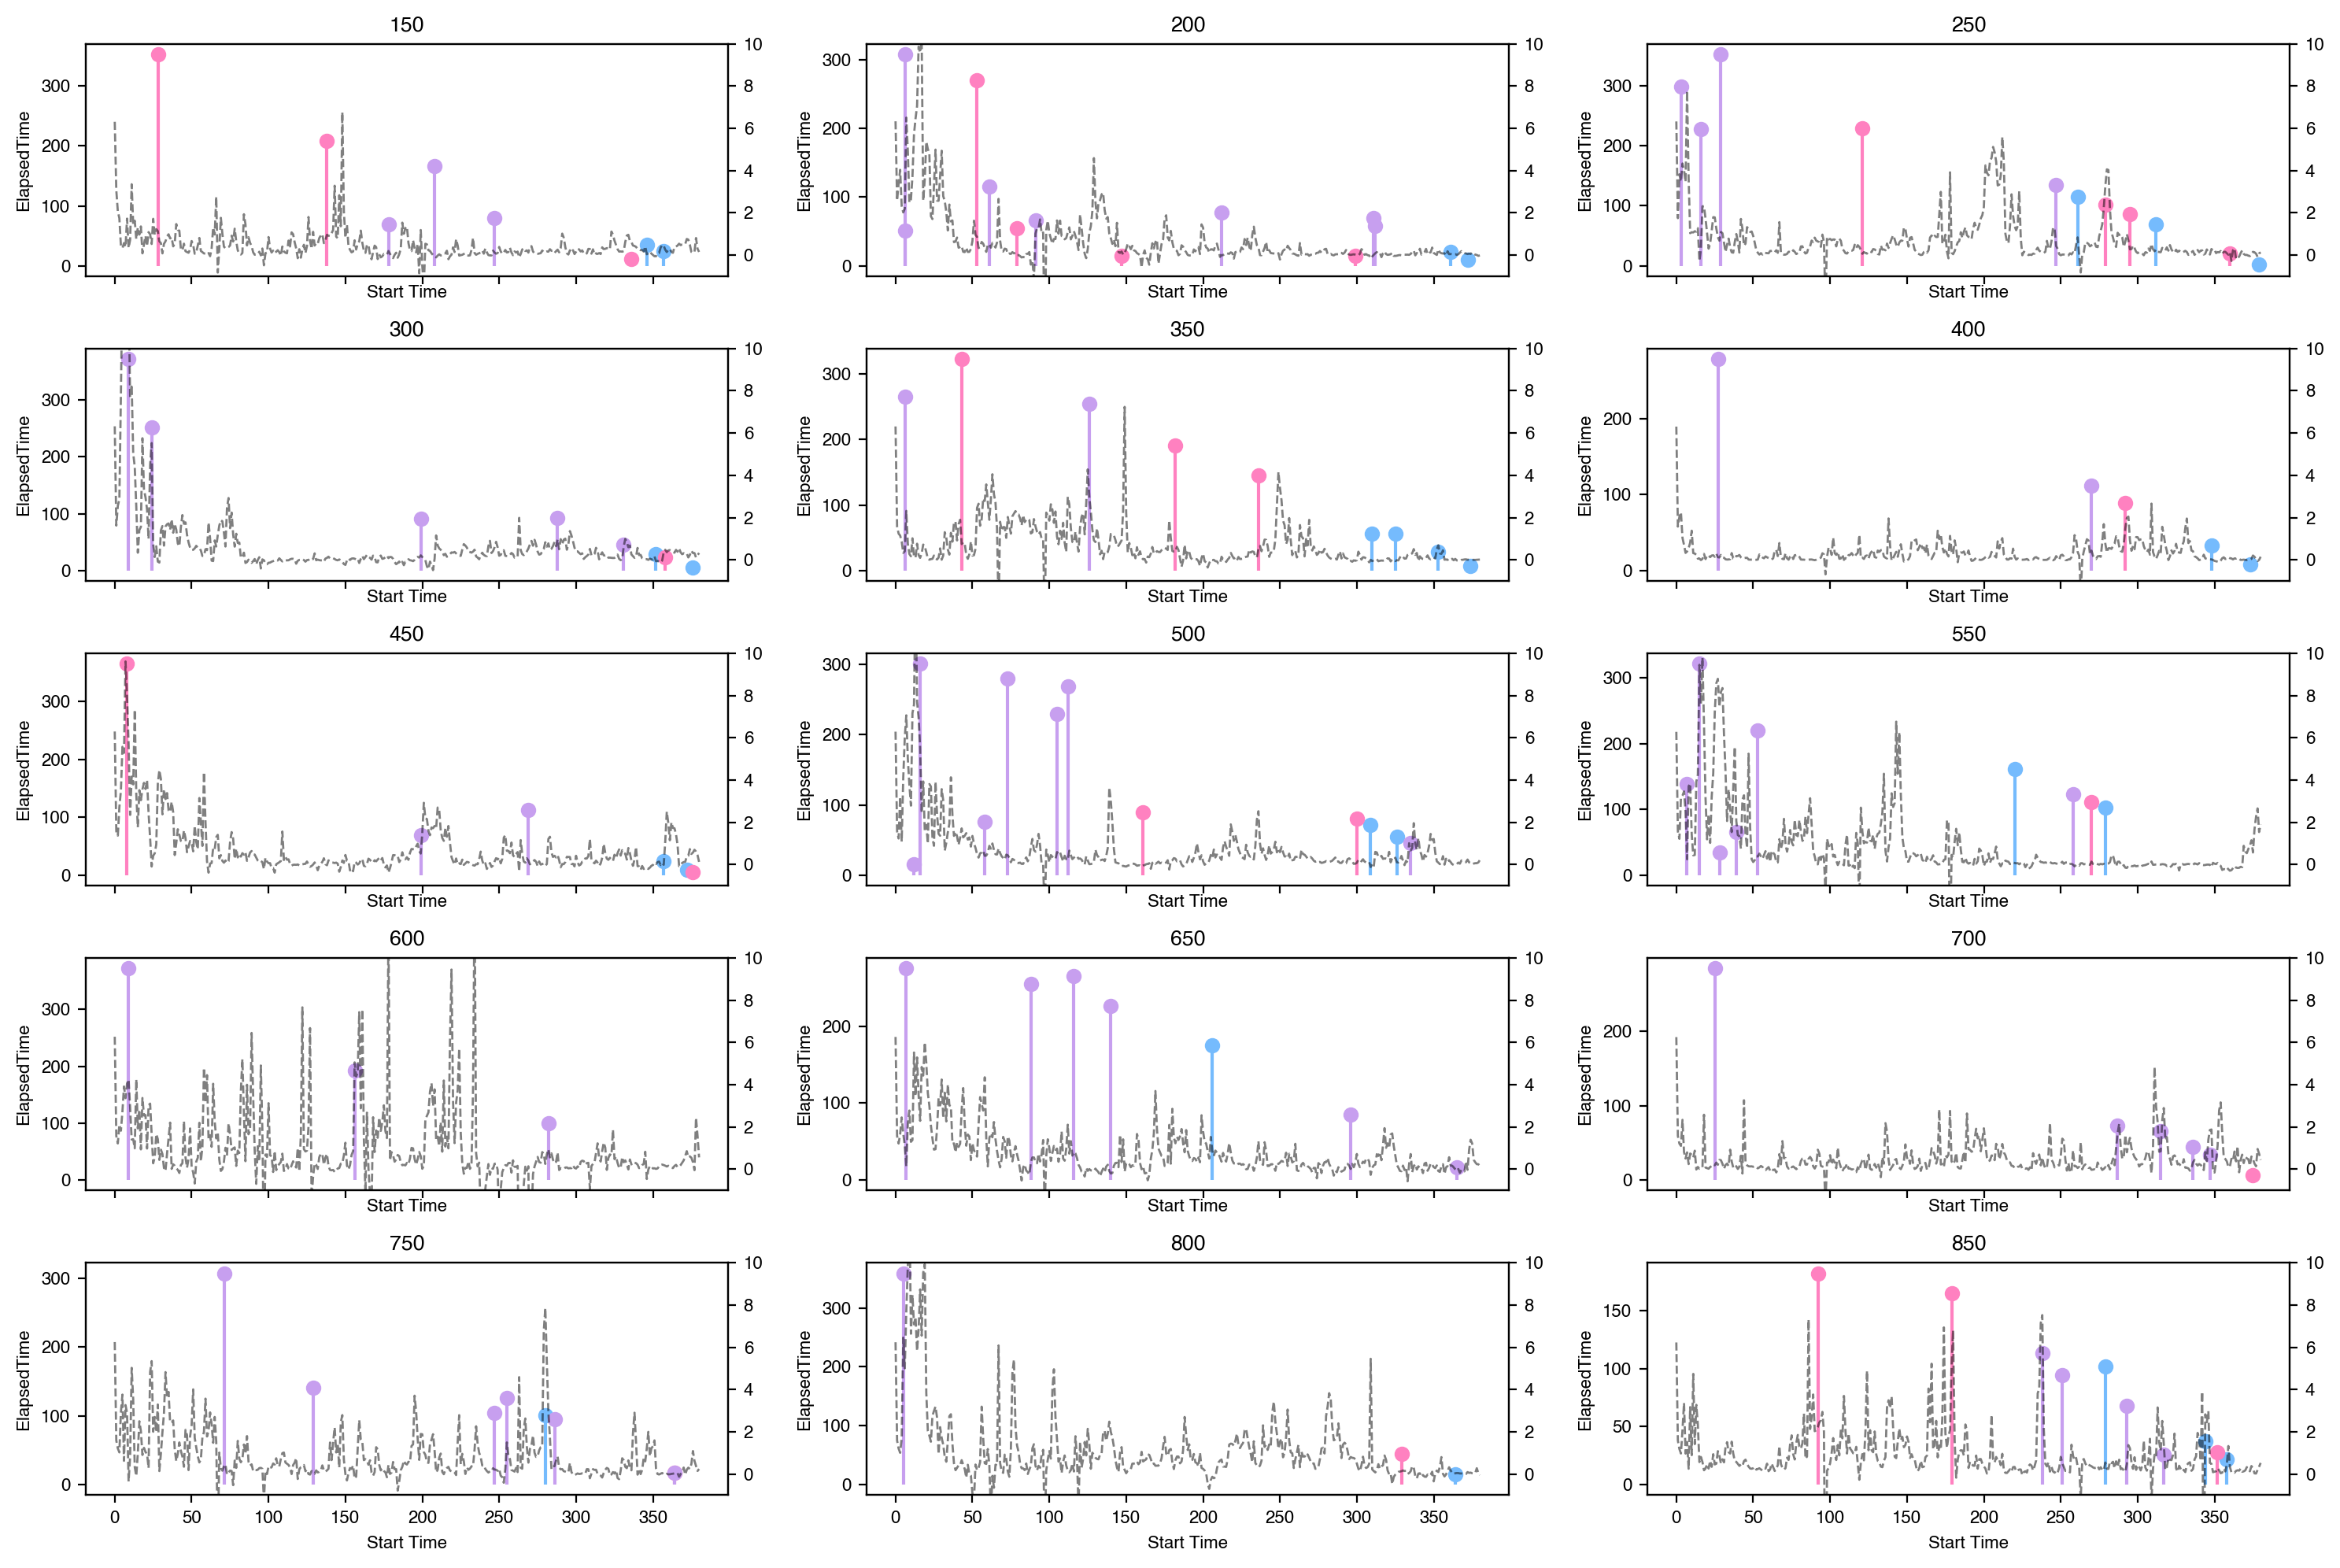

In [36]:
ilocs = np.arange(150, 900, 50)
times = np.arange(total_wr_2h.shape[1])
fig, ax = plt.subplots(len(ilocs)//3, 3, figsize = (15, 10), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    
    ax2 = ax[idx].twinx()
    ax2.plot(times, total_wr_2h[i, :], 'k--', label = 'RB', lw = 1, zorder=0, alpha = .5) ## this is the indexing to get one row

    ax2.set_ylim(-1, 10)
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)

    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

### Preservation bar charts

<AxesSubplot:xlabel='process interp', ylabel='count'>

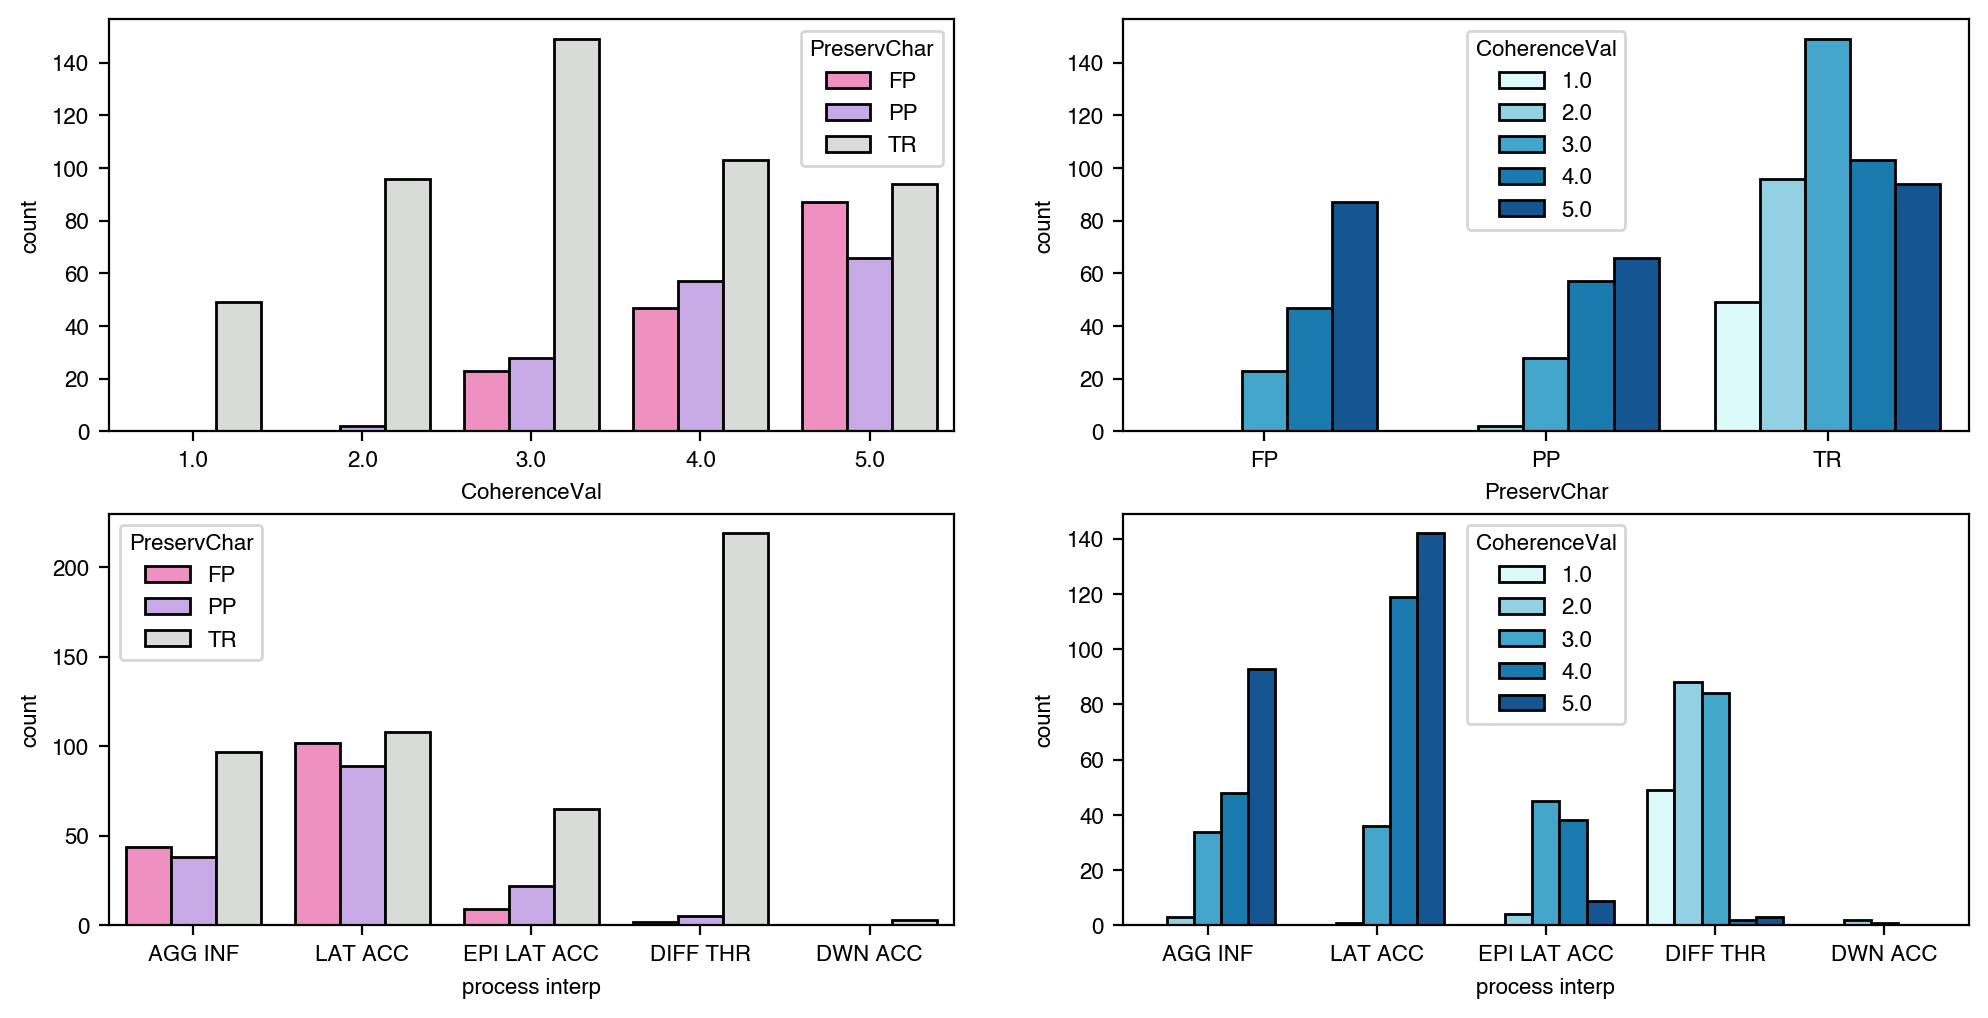

In [119]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6), dpi = 200)
sns.countplot(x = 'CoherenceVal', hue = allbars['PreservChar'], data = allbars, palette = pres_palette, edgecolor = 'k', ax = ax[0, 0])
sns.countplot(x = 'PreservChar', hue = allbars['CoherenceVal'], data = allbars, palette = coh_palette, edgecolor = 'k', ax = ax[0, 1])

sns.countplot(x = 'process interp', hue = allbars['PreservChar'], data = allbars, palette = pres_palette, edgecolor = 'k', ax = ax[1, 0])
sns.countplot(x = 'process interp', hue = allbars['CoherenceVal'], data = allbars, palette = coh_palette, edgecolor = 'k', ax = ax[1, 1])

### Cross Plots, don't run

<Figure size 1080x1080 with 0 Axes>

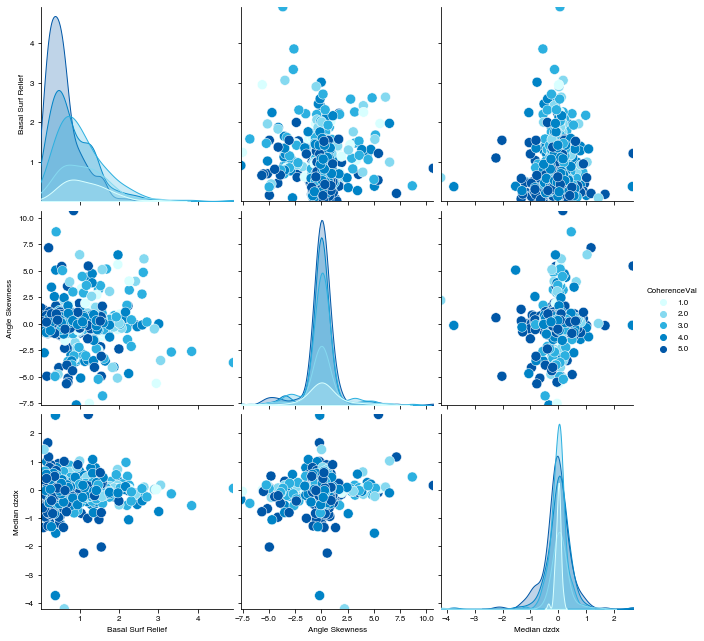

In [19]:
plt.figure(figsize = (15, 15))
pplot = sns.pairplot(allbars,
                     plot_kws=dict(marker="o", linewidth=0.5, s = 100, edgecolor = 'w'),
                     vars = ['Basal Surf Relief', 'Angle Skewness', 'Median dzdx'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = coh_palette)
snsvars = ['Basal Surf Relief', 'Angle Skewness', 'Median dzdx']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

# pplot.set(xlim=(0, None))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

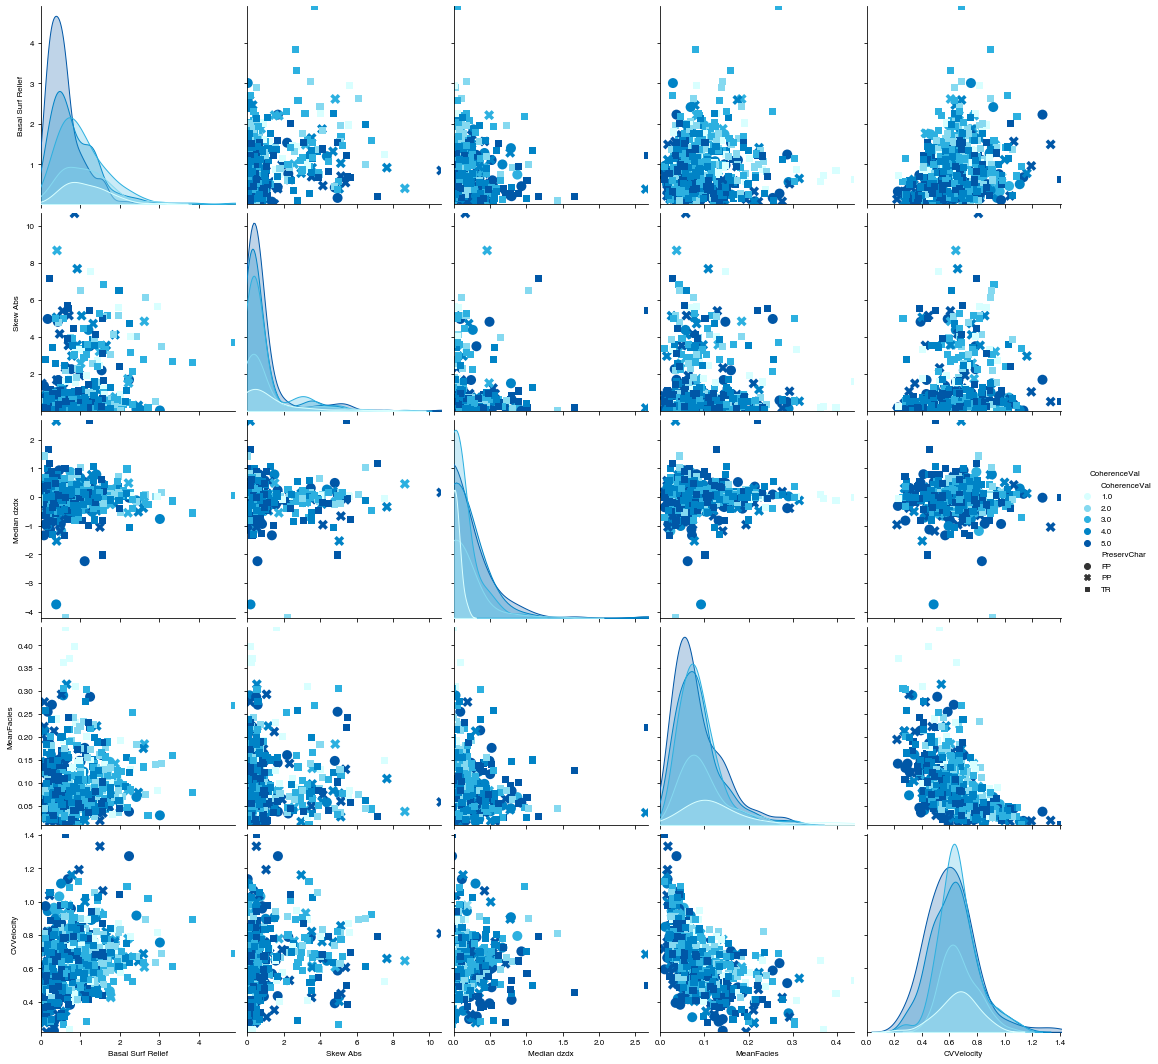

In [20]:
plt.figure(figsize = (15, 15))
pplot = sns.pairplot(allbars,
                     plot_kws=dict(style = allbars['PreservChar'], linewidth=0, s = 100, edgecolor = 'w'),
                     vars = ['Basal Surf Relief', 'Skew Abs', 'Median dzdx', 'MeanFacies', 'CVVelocity'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = coh_palette)
snsvars = ['Basal Surf Relief', 'Skew Abs', 'Median dzdx', 'MeanFacies', 'CVVelocity']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

# pplot.map_lower(sns.kdeplot, levels=2, color="w")

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

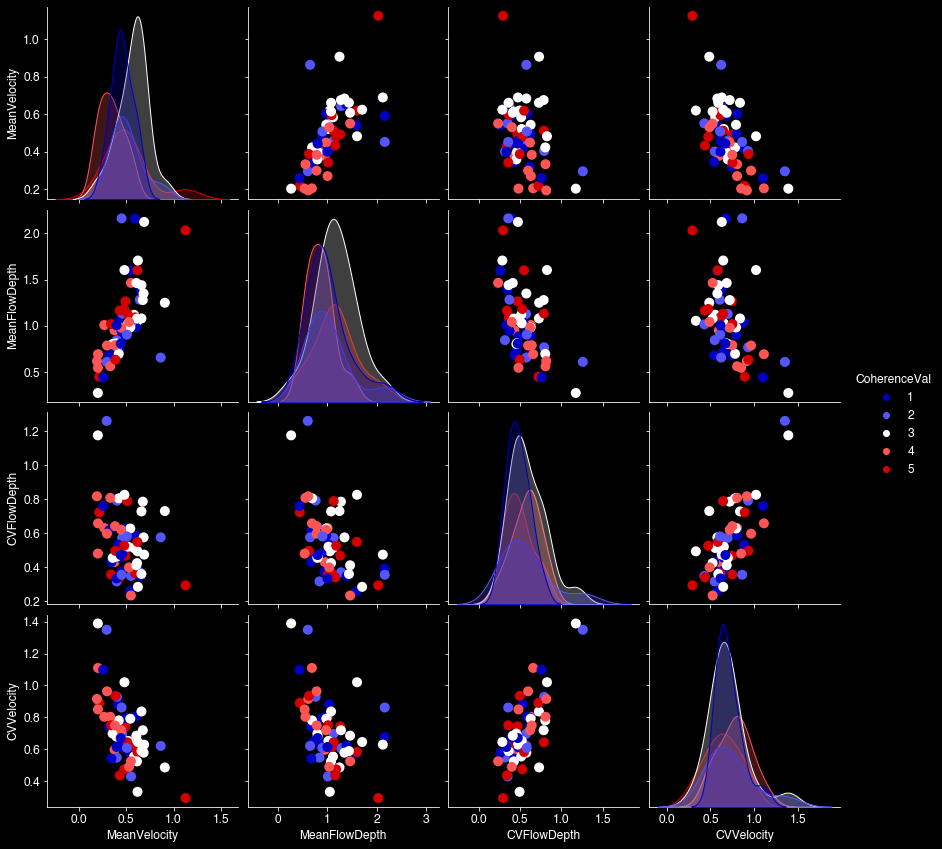

In [152]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    sns.pairplot(allbars, plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'), 
                 vars = ['MeanVelocity', 'MeanFlowDepth', 'CVFlowDepth', 'CVVelocity'],
                hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 5))
    snsvars = ['MeanVelocity', 'MeanFlowDepth', 'CVFlowDepth', 'CVVelocity']
    
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))
        
    for i, v in enumerate(snsvars):
        pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 1440x1080 with 0 Axes>

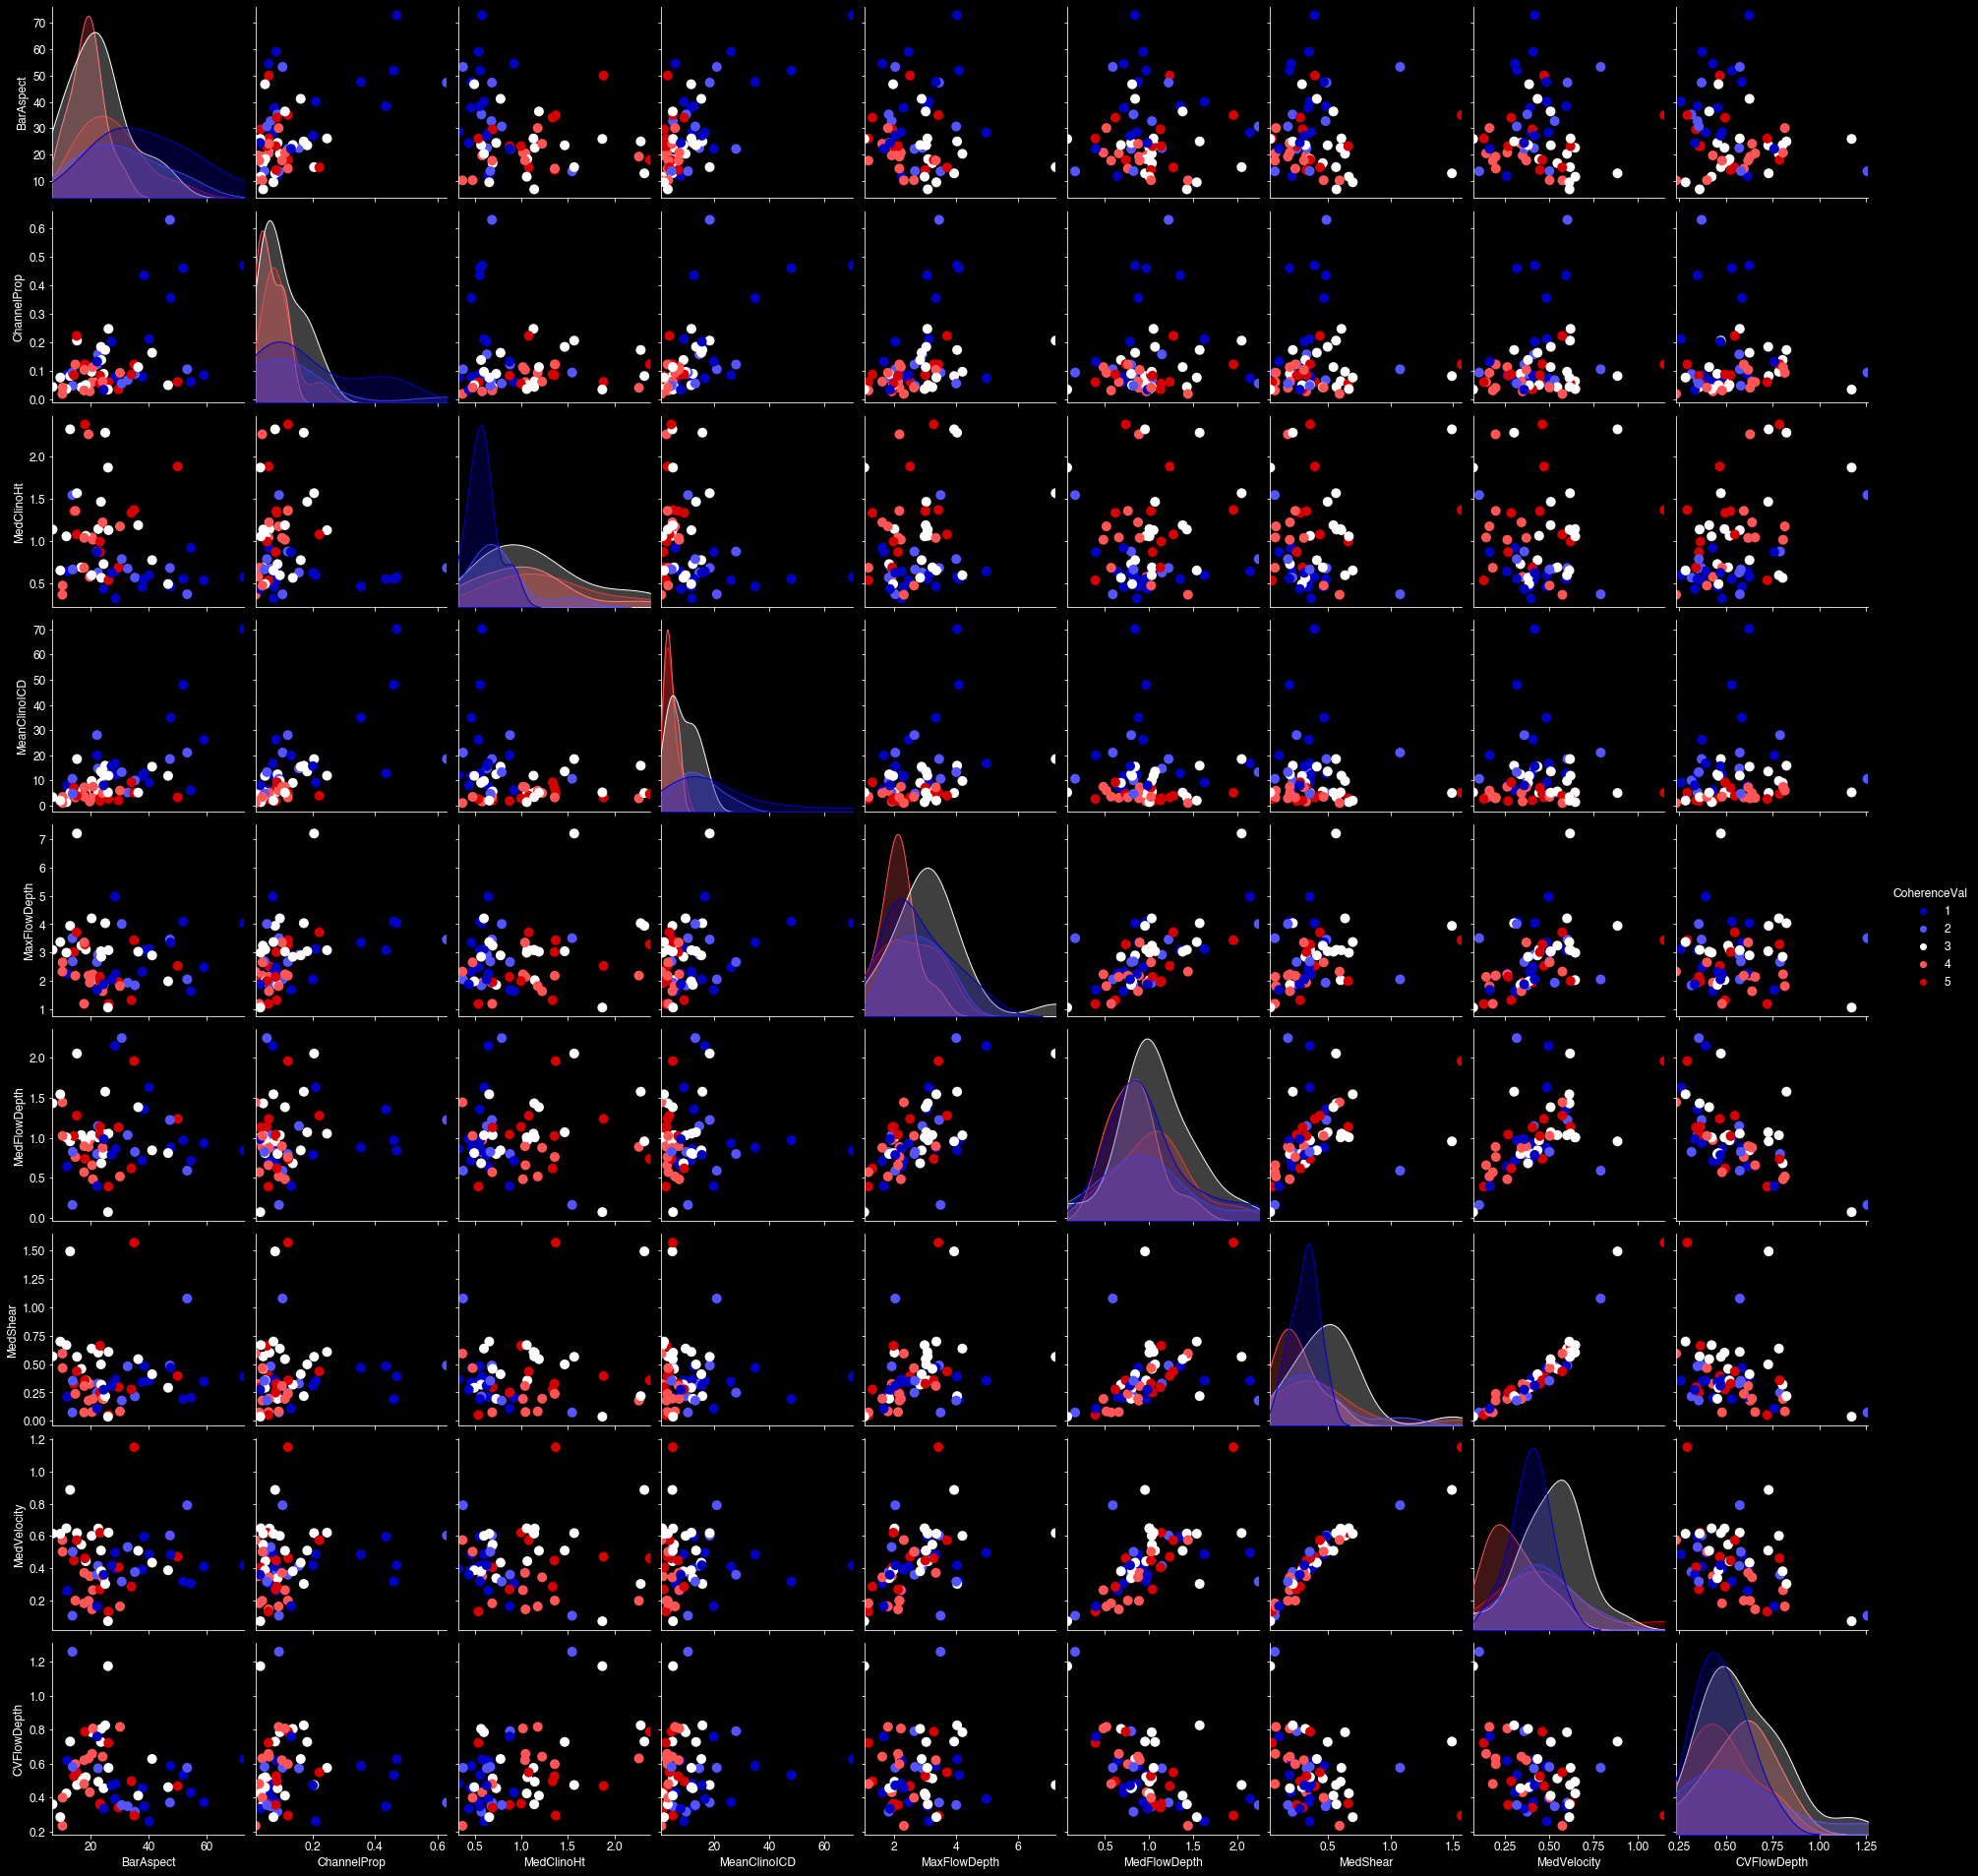

In [155]:
plt.figure(figsize = (20, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars, 
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 5))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Skew Abs', 'Basal Surf Relief']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

    # pplot.set(xlim=(0, None))
    # pplot.axes[-1, 0].set(xlim=(0, 600))
    # plt.savefig(f'{savefilesto}/pairplot-test.png', dpi = 200)

In [32]:
sns.mpl_palette('seismic', 3)

[(0.00392156862745098, 0.00392156862745098, 1.0),
 (1.0, 0.9921568627450981, 0.9921568627450981),
 (0.9941176470588236, 0.0, 0.0)]

ValueError: The palette list has the wrong number of colors.

<Figure size 1080x1080 with 0 Axes>

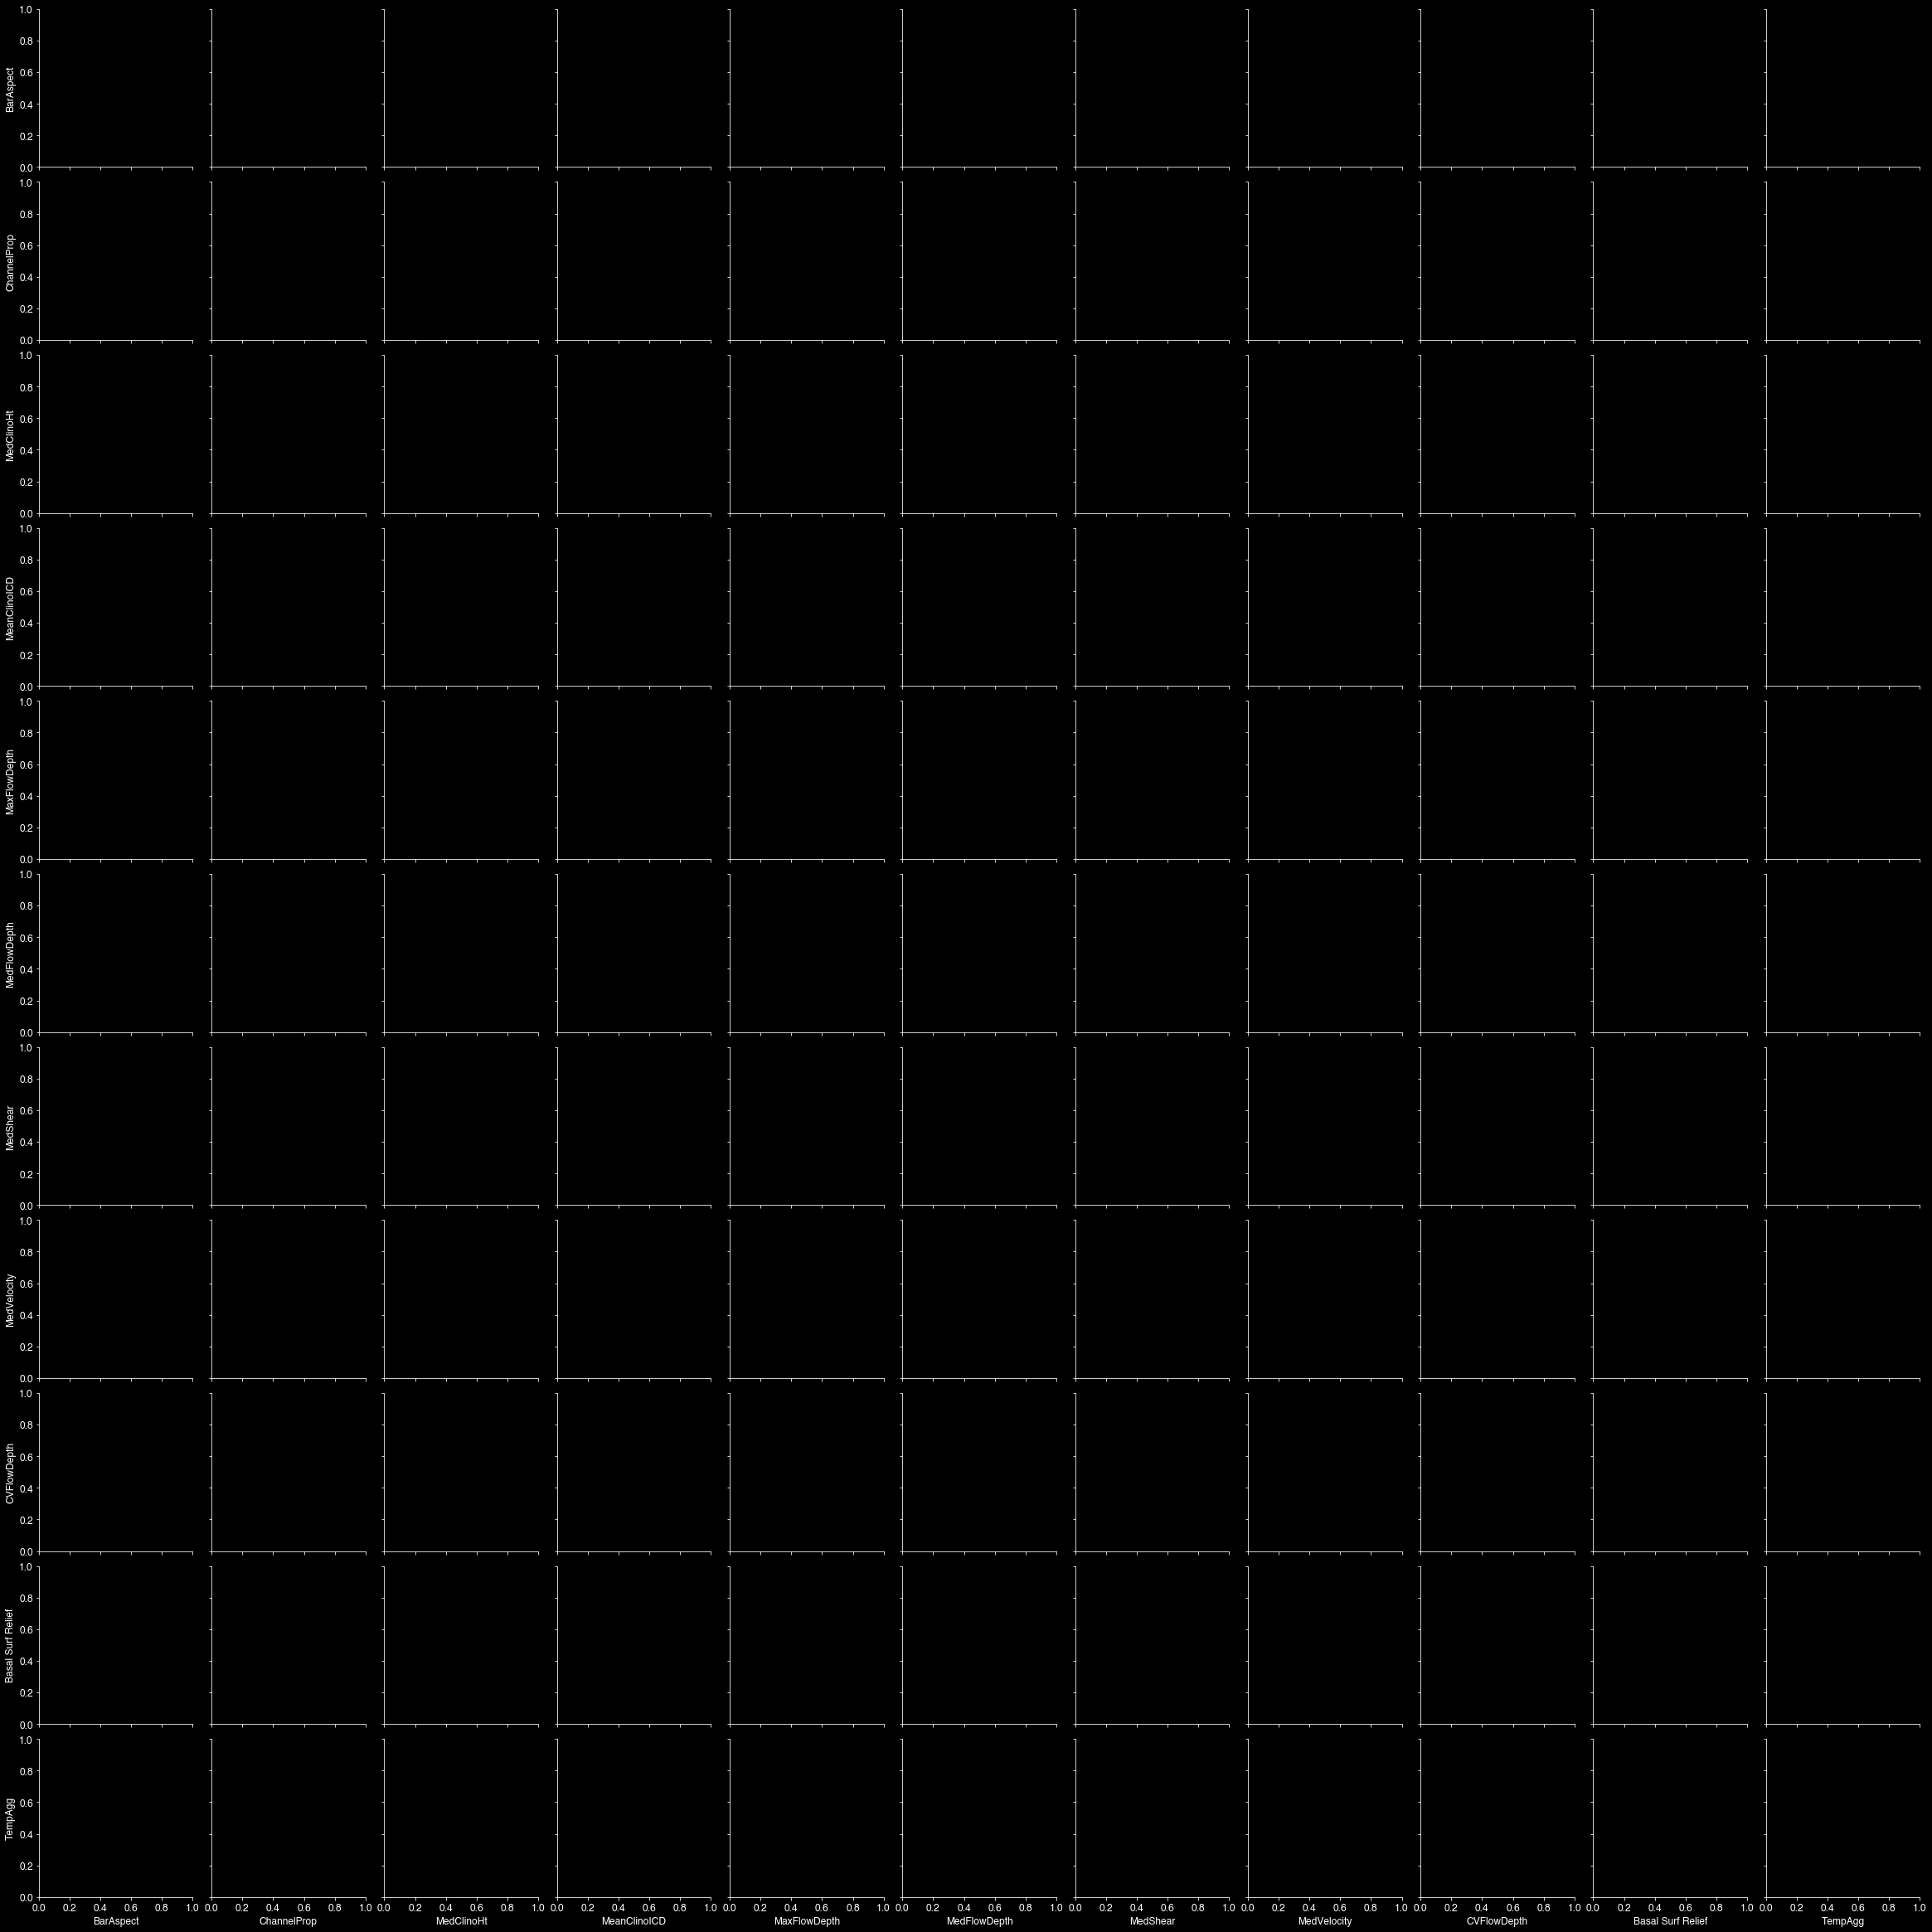

In [38]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Basal Surf Relief', 'TempAgg'], hue = 'Skew Binned', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 3))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness', 'TempAgg']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbskew.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

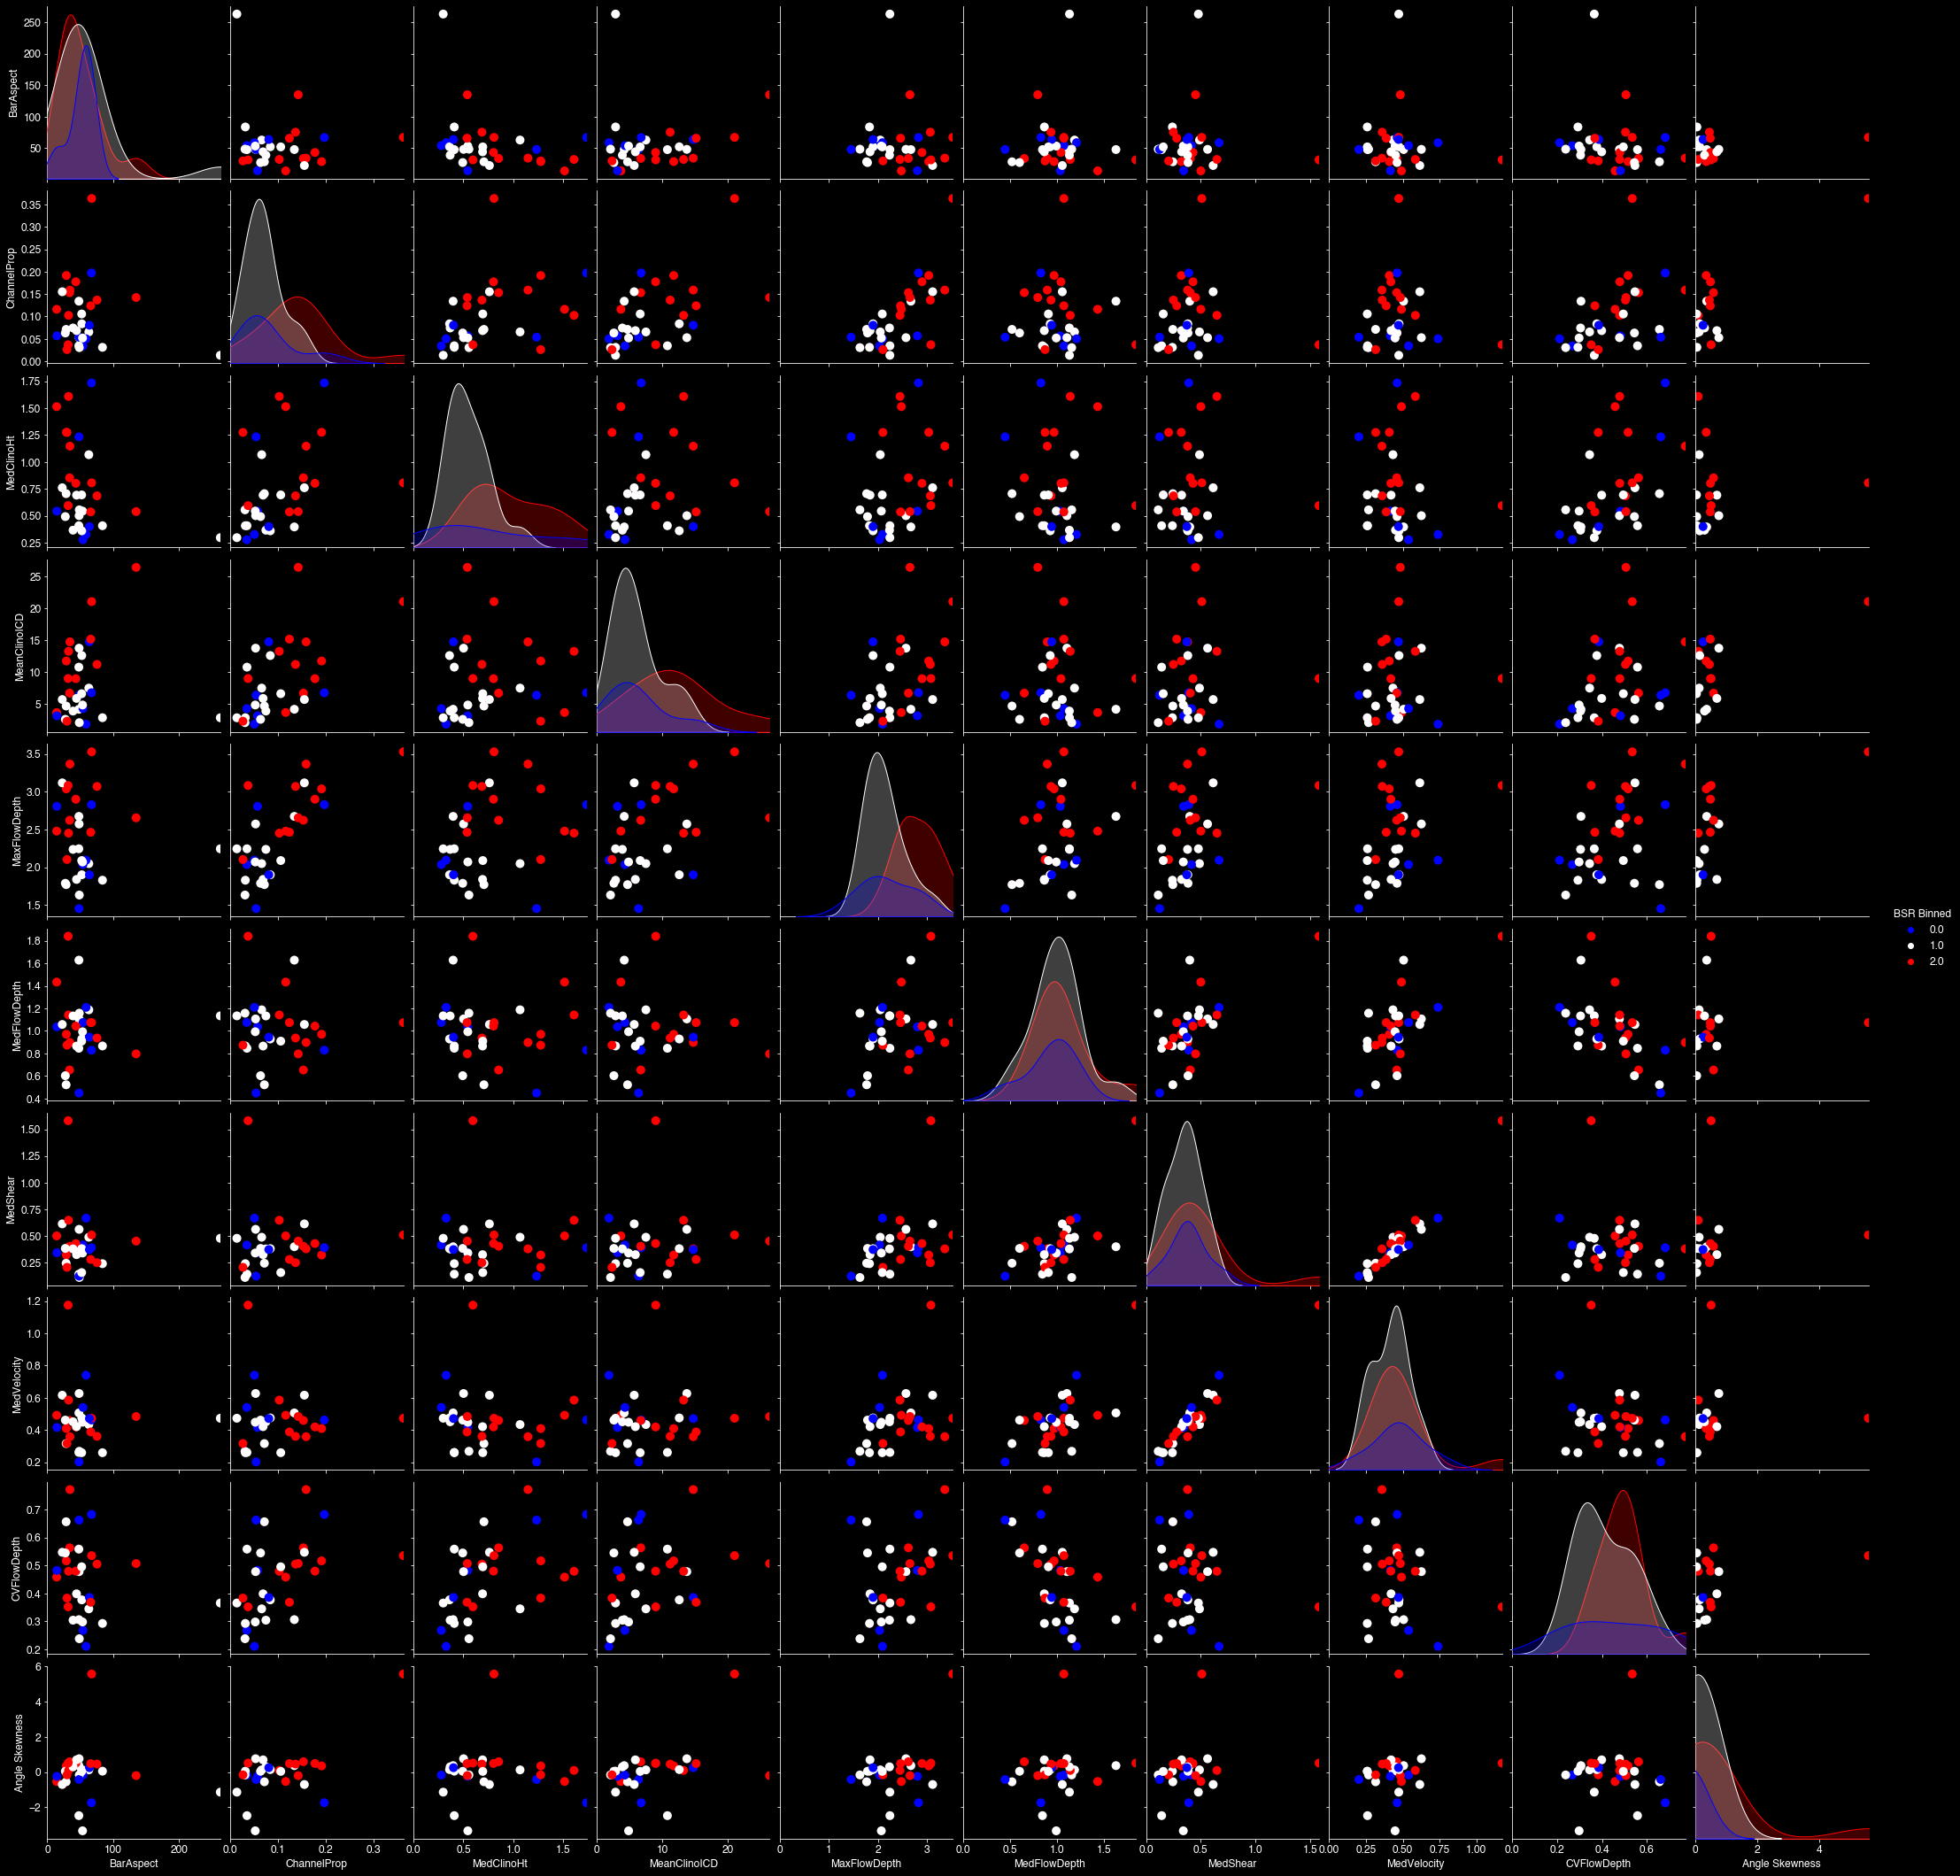

In [49]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness'], hue = 'BSR Binned', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 3))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

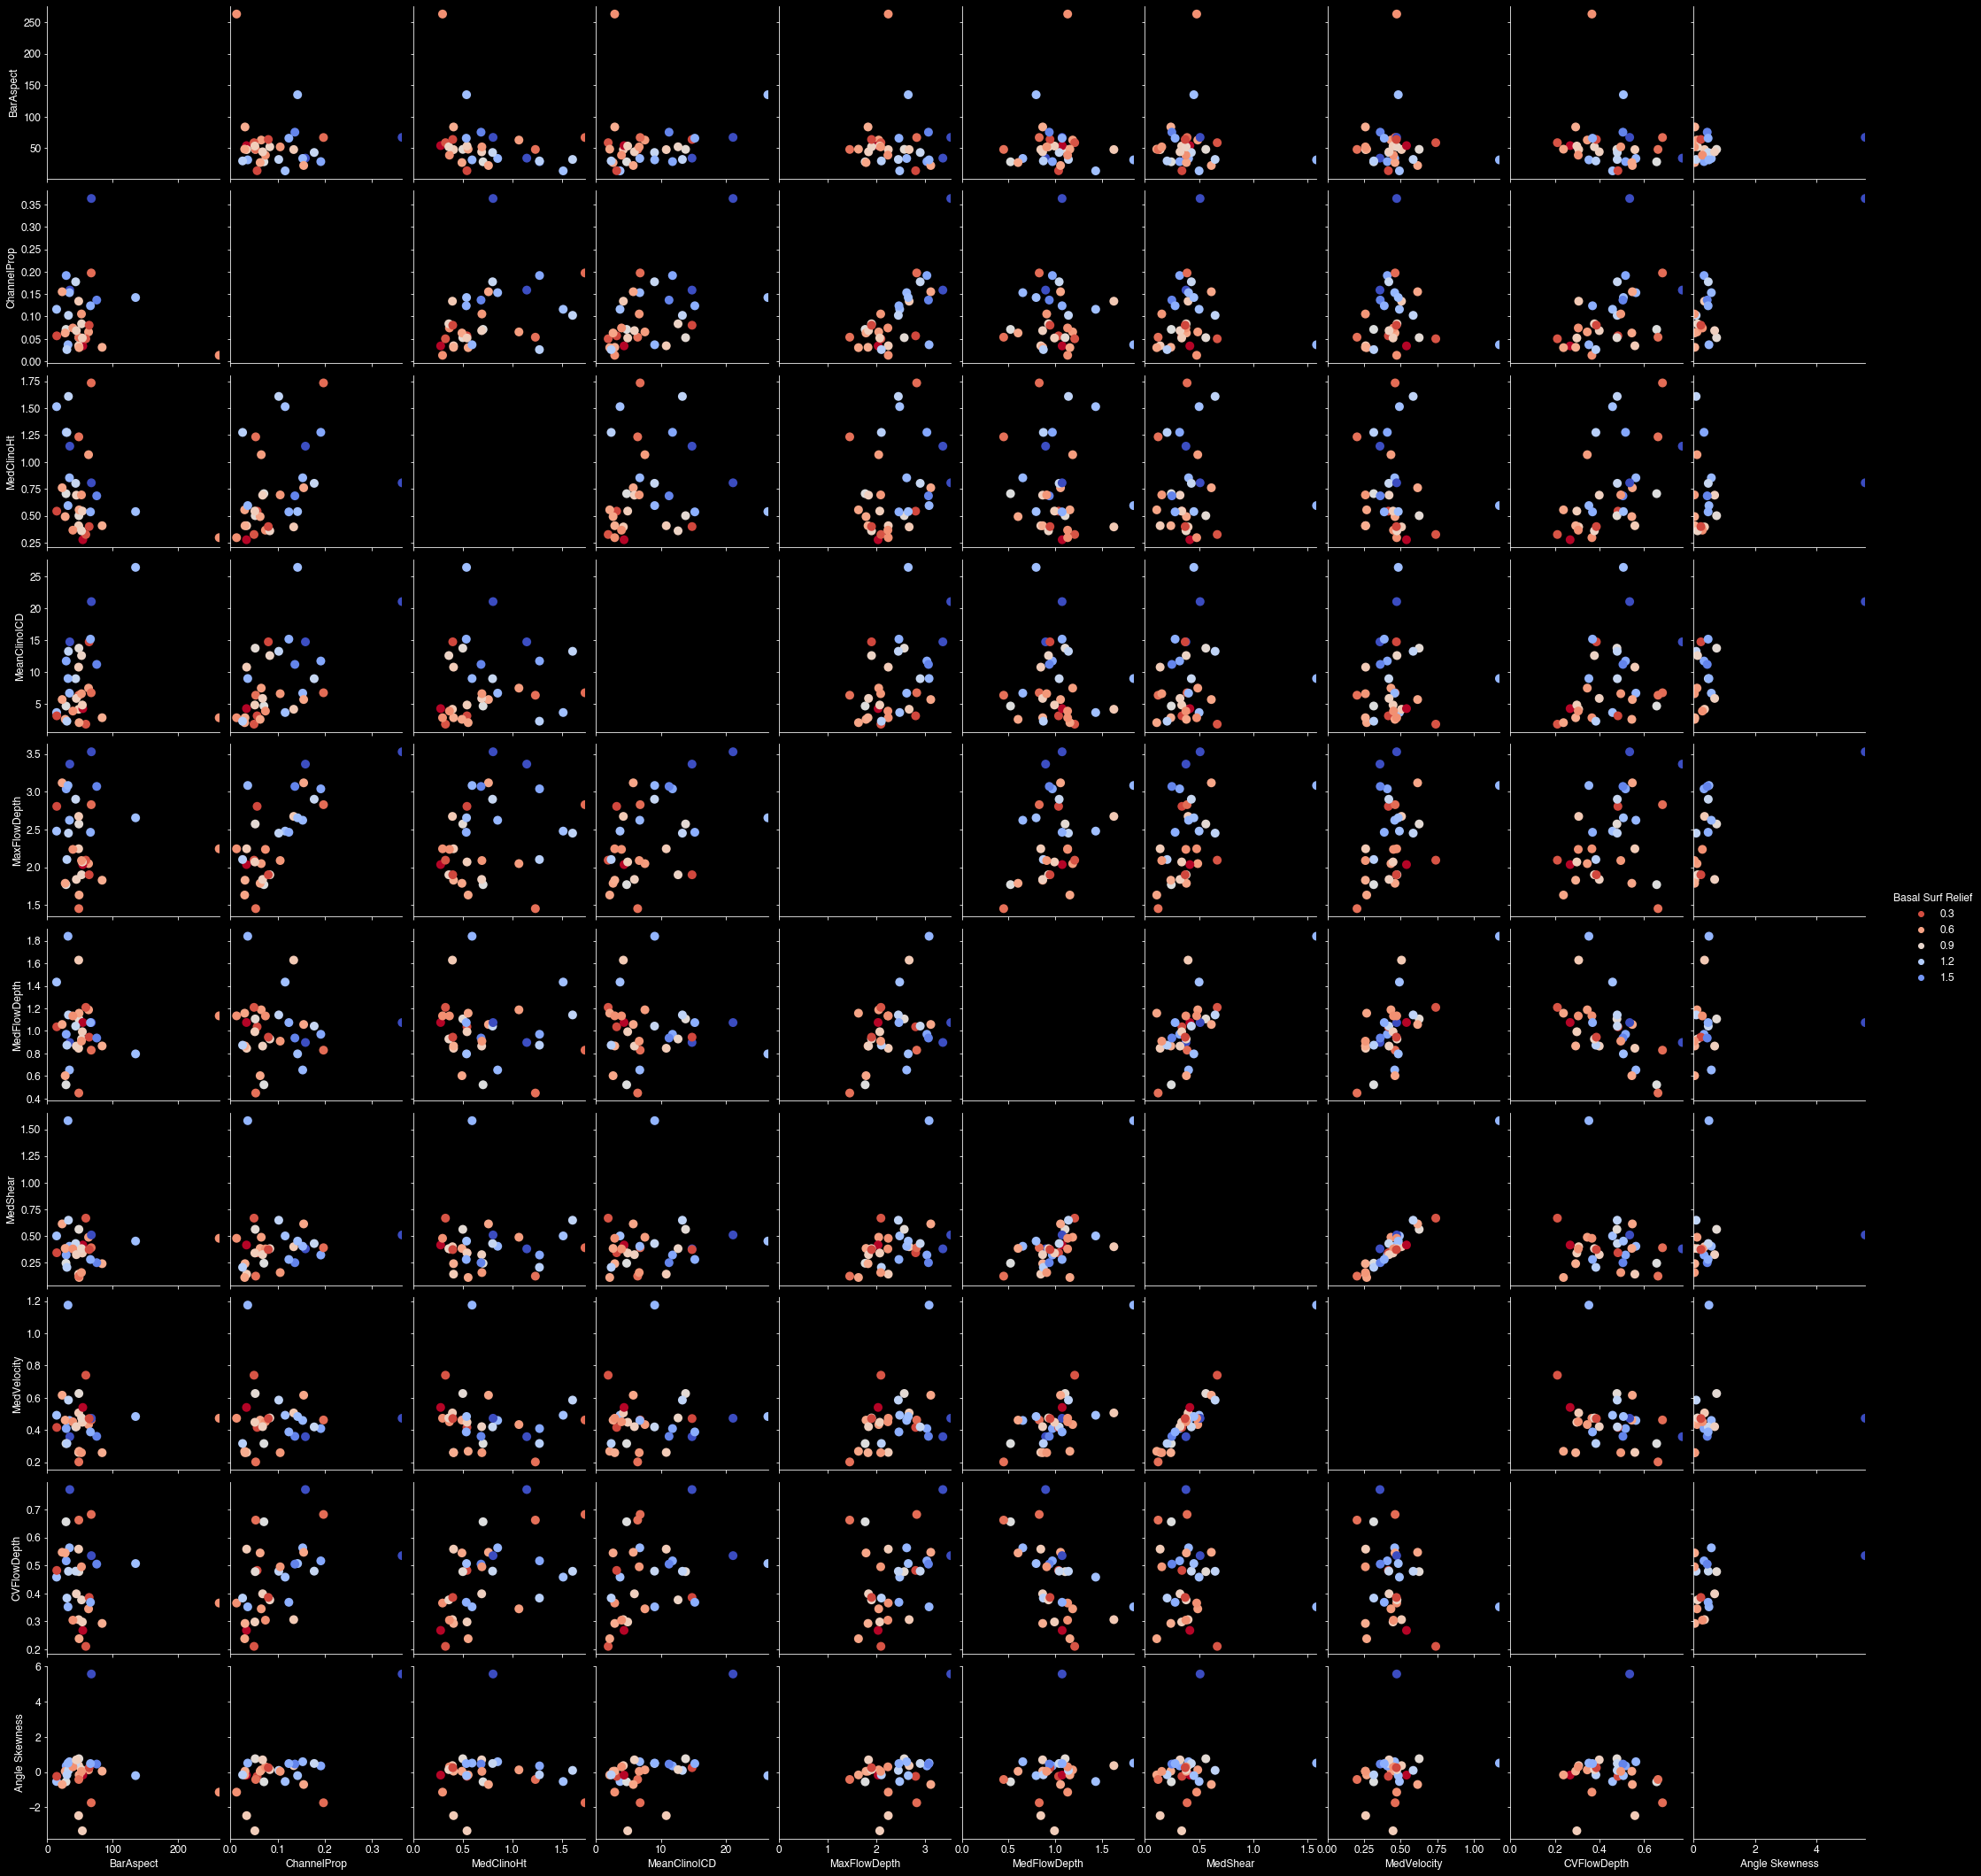

In [18]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness'], hue = 'Basal Surf Relief', height = 3, aspect = 1, palette = 'coolwarm_r')
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbbsr.png', dpi = 200)

In [28]:
pplot = sns.pairplot(allbars, vars = ['Angle Skewness', 'Basal Surf Relief'], hue =allbars['BarHeight'], palette = 'Spectral')
plot_kws={"s": 3}

snsvars = ['Angle Skewness', 'Basal Surf Relief']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))
    
# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbskew.png', dpi = 200)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
sns.scatterplot(allbars['Angle Skewness'], allbars['Basal Surf Relief'], hue = allbars[''])

### Violin & Box Plots

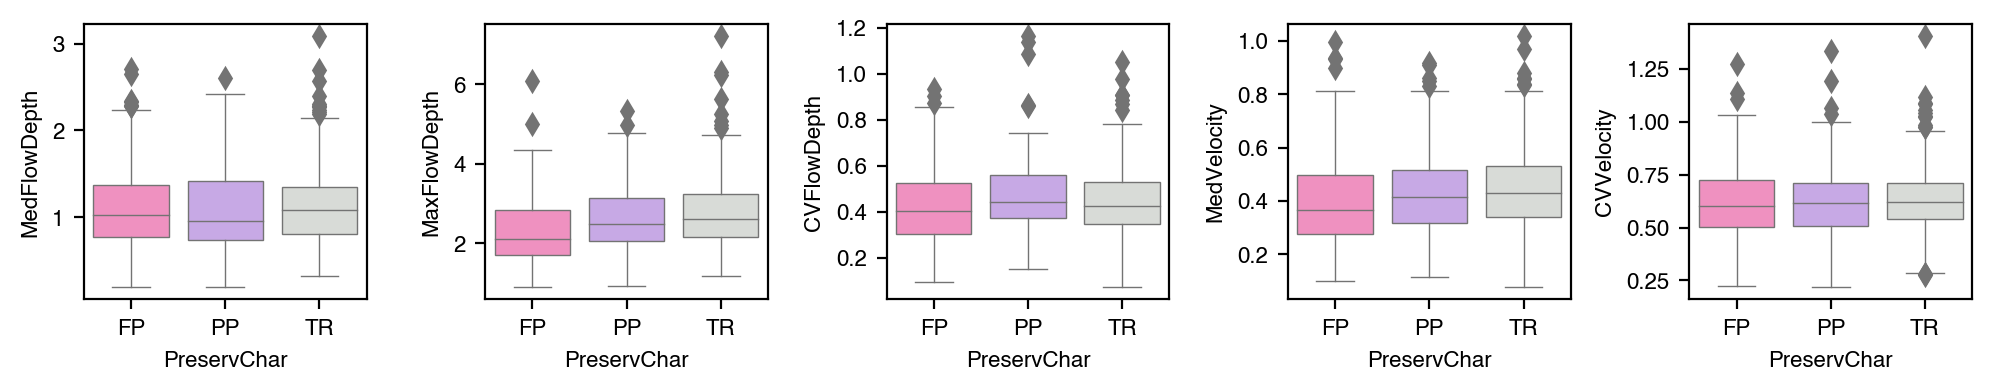

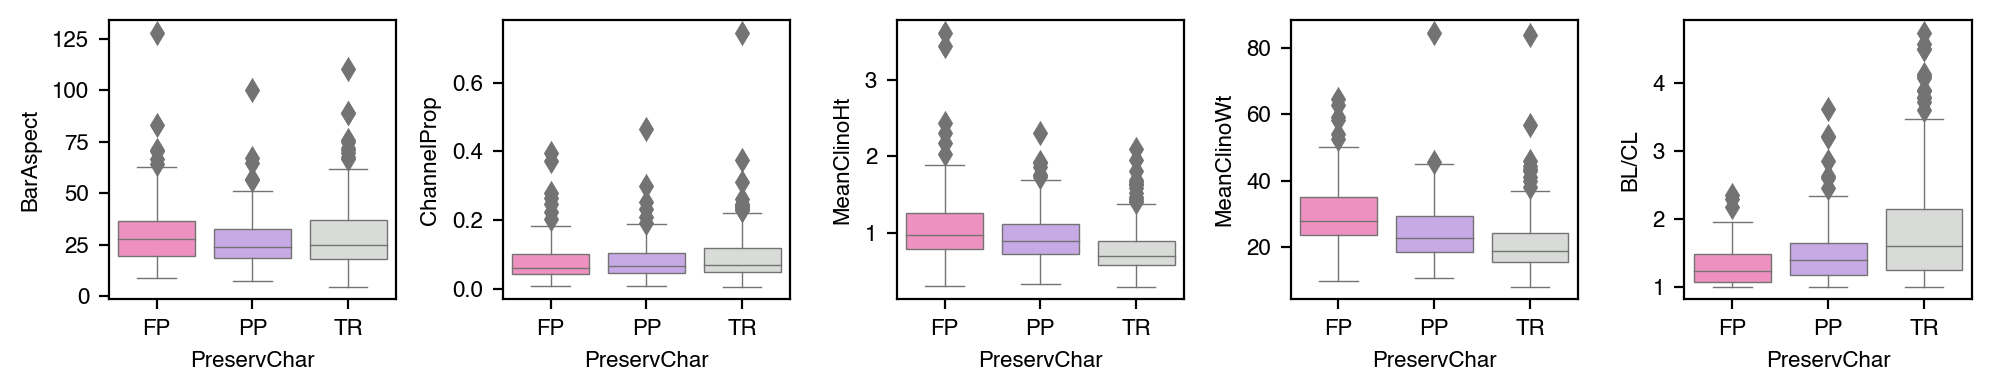

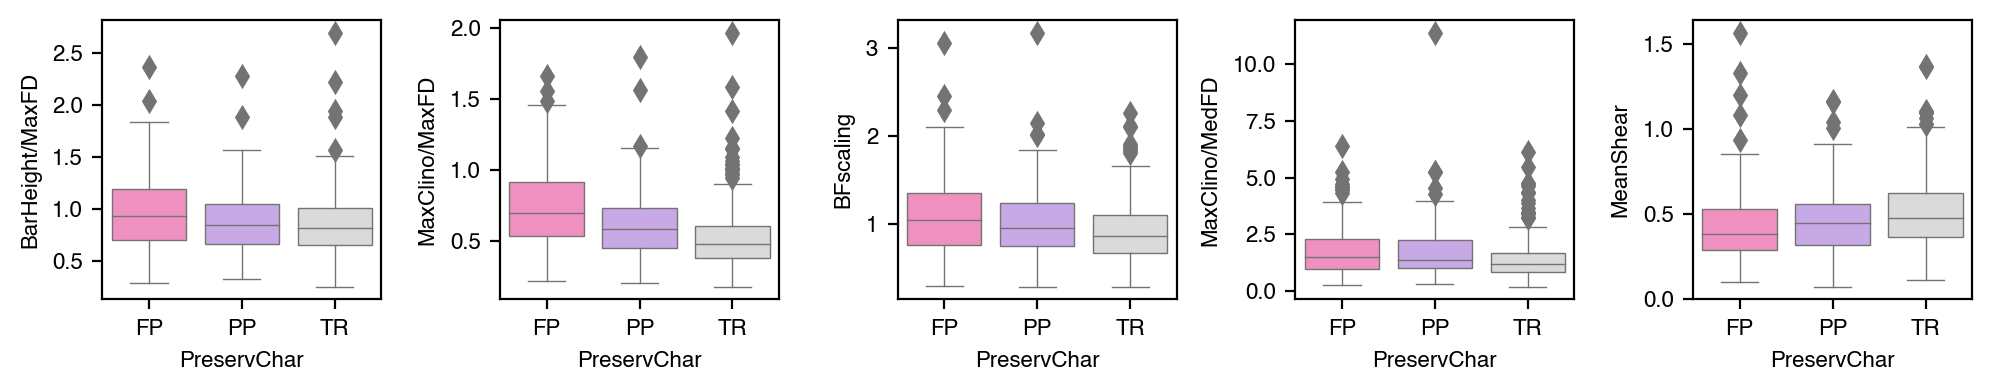

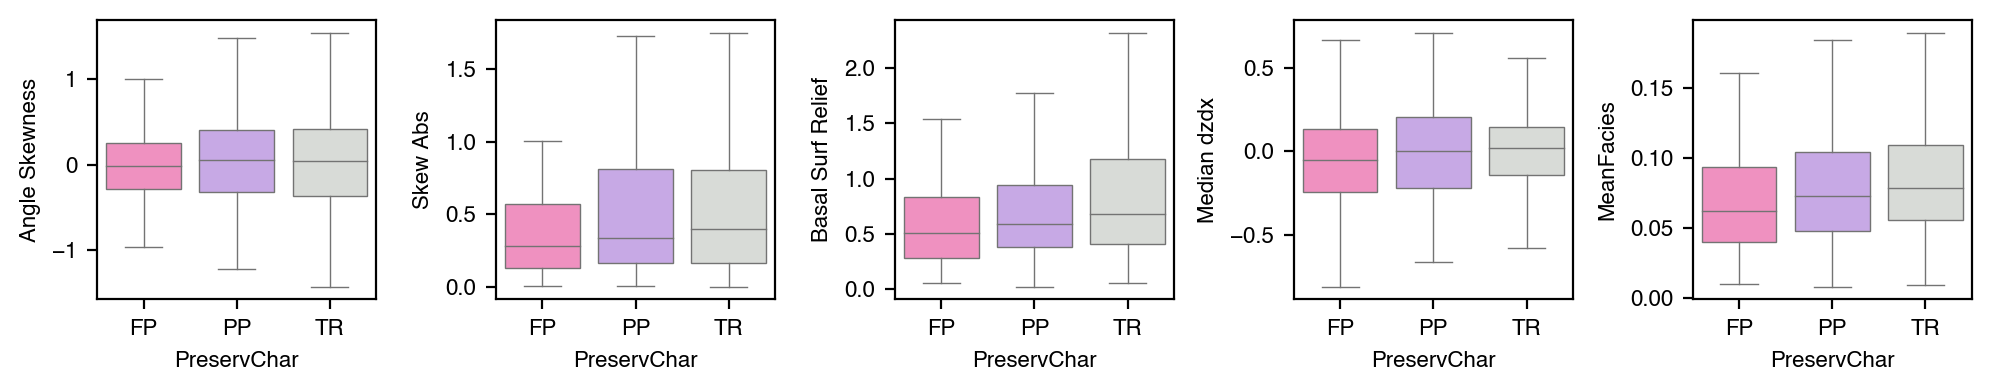

In [36]:
hydraulic_vars = ['MedFlowDepth', 'MaxFlowDepth','CVFlowDepth', 'MedVelocity', 'CVVelocity']
geometric_vars = ['BarAspect', 'ChannelProp', 'MeanClinoHt', 'MeanClinoWt', 'BL/CL']
scalers = ['BarHeight/MaxFD', 'MaxClino/MaxFD', 'BFscaling', 'MaxClino/MedFD', 'MeanShear']
diagnostics = ['Angle Skewness', 'Skew Abs', 'Basal Surf Relief', 'Median dzdx', 'MeanFacies']
fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    #sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = hydraulic_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = hydraulic_vars[i], palette = pres_palette, ax = a, linewidth = 0.5)#, bw = 0.5)
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = 0.5)#, bw = 0.5)    
fig, ax = plt.subplots(1, len(scalers), figsize = (10, 2), dpi = 200, tight_layout = True)
# ax[3].set_ylim(0, 2)
# ax[2].set_ylim(0, 2)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = pres_palette, ax = a, linewidth = 0.5)#, bw = 0.5)

fig, ax = plt.subplots(1, len(diagnostics), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    #sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = hydraulic_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = diagnostics[i], palette = pres_palette, ax = a, linewidth = 0.5, showfliers = False)#, bw = 0.5)

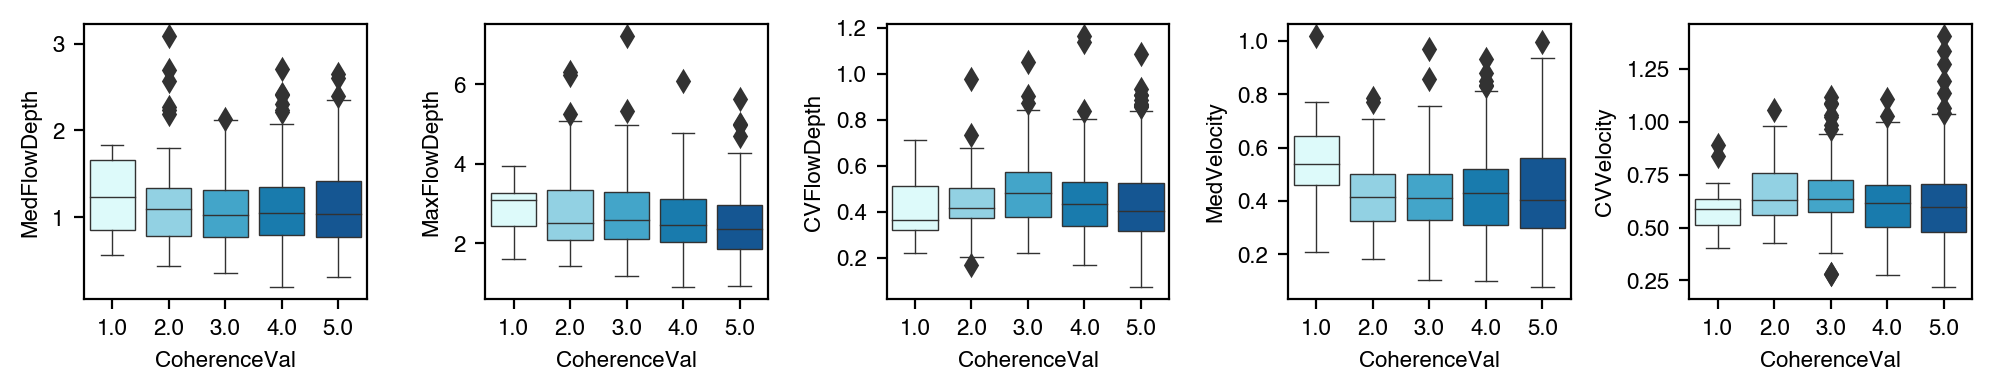

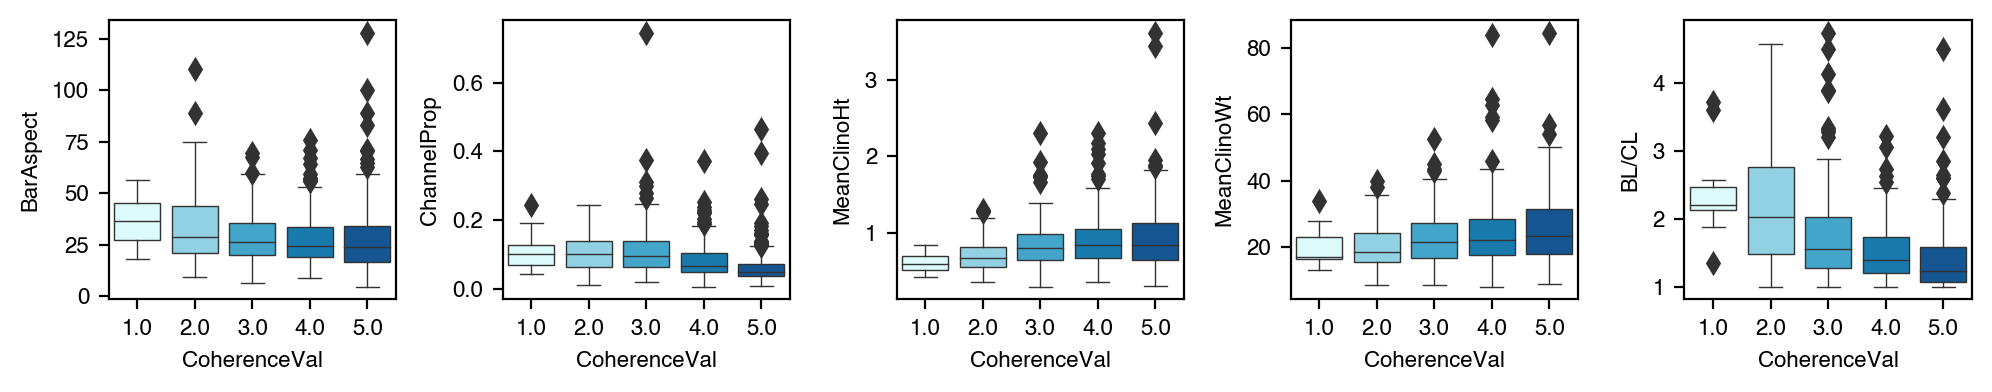

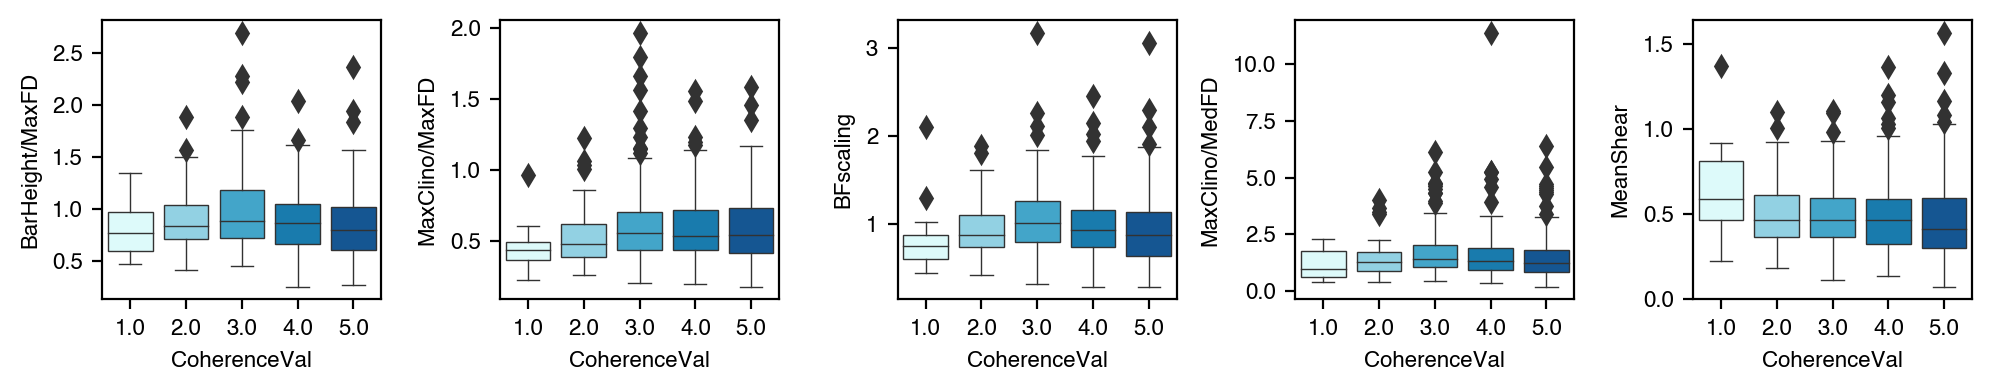

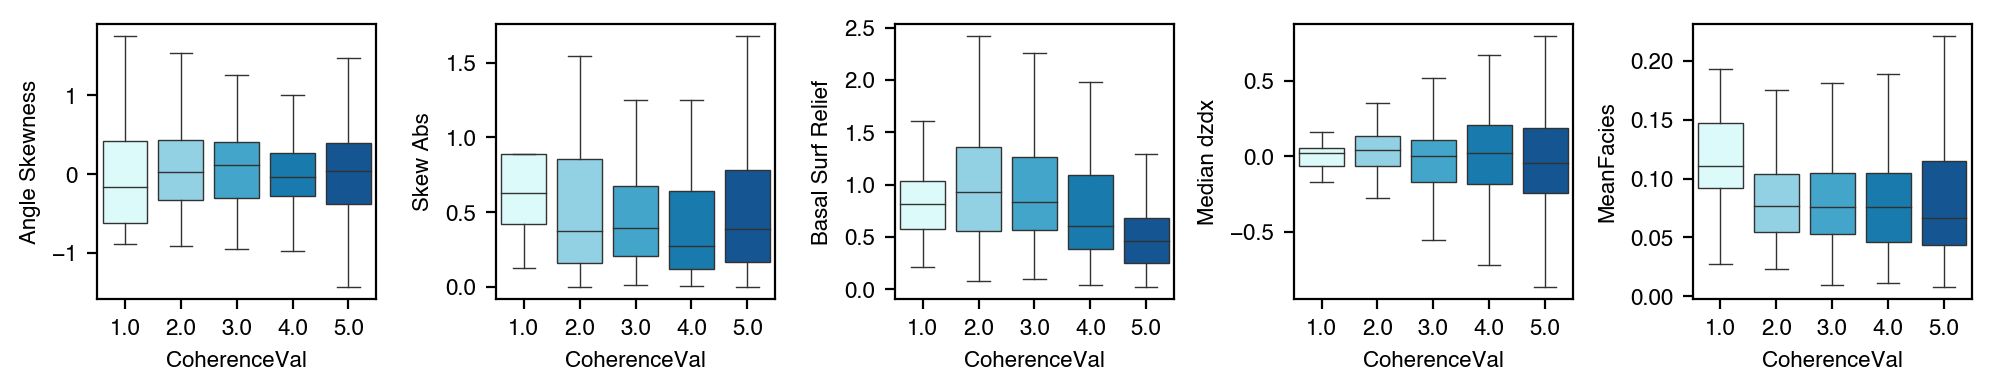

In [37]:
fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'CoherenceVal', y = hydraulic_vars[i], palette = coh_palette, ax = a, linewidth = 0.5, showfliers=True)#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'CoherenceVal', y = geometric_vars[i], palette = coh_palette, ax = a, linewidth = 0.5, showfliers=True)#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(scalers), figsize = (10, 2), dpi = 200, tight_layout = True)
# ax[3].set_ylim(0, 2)
# ax[2].set_ylim(0, 2)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'CoherenceVal', y = scalers[i], palette = coh_palette, ax = a, linewidth = 0.5, showfliers=True)#, bw = 0.5)

fig, ax = plt.subplots(1, len(diagnostics), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'CoherenceVal', y = diagnostics[i], palette = coh_palette, ax = a, linewidth = 0.5, showfliers=False)#, bw = 0.5)

# fig, ax = plt.subplots(1, len(scalers), figsize = (10, 3), dpi = 200, tight_layout = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], hue = 'BinFacMean', ax = a, split = True)


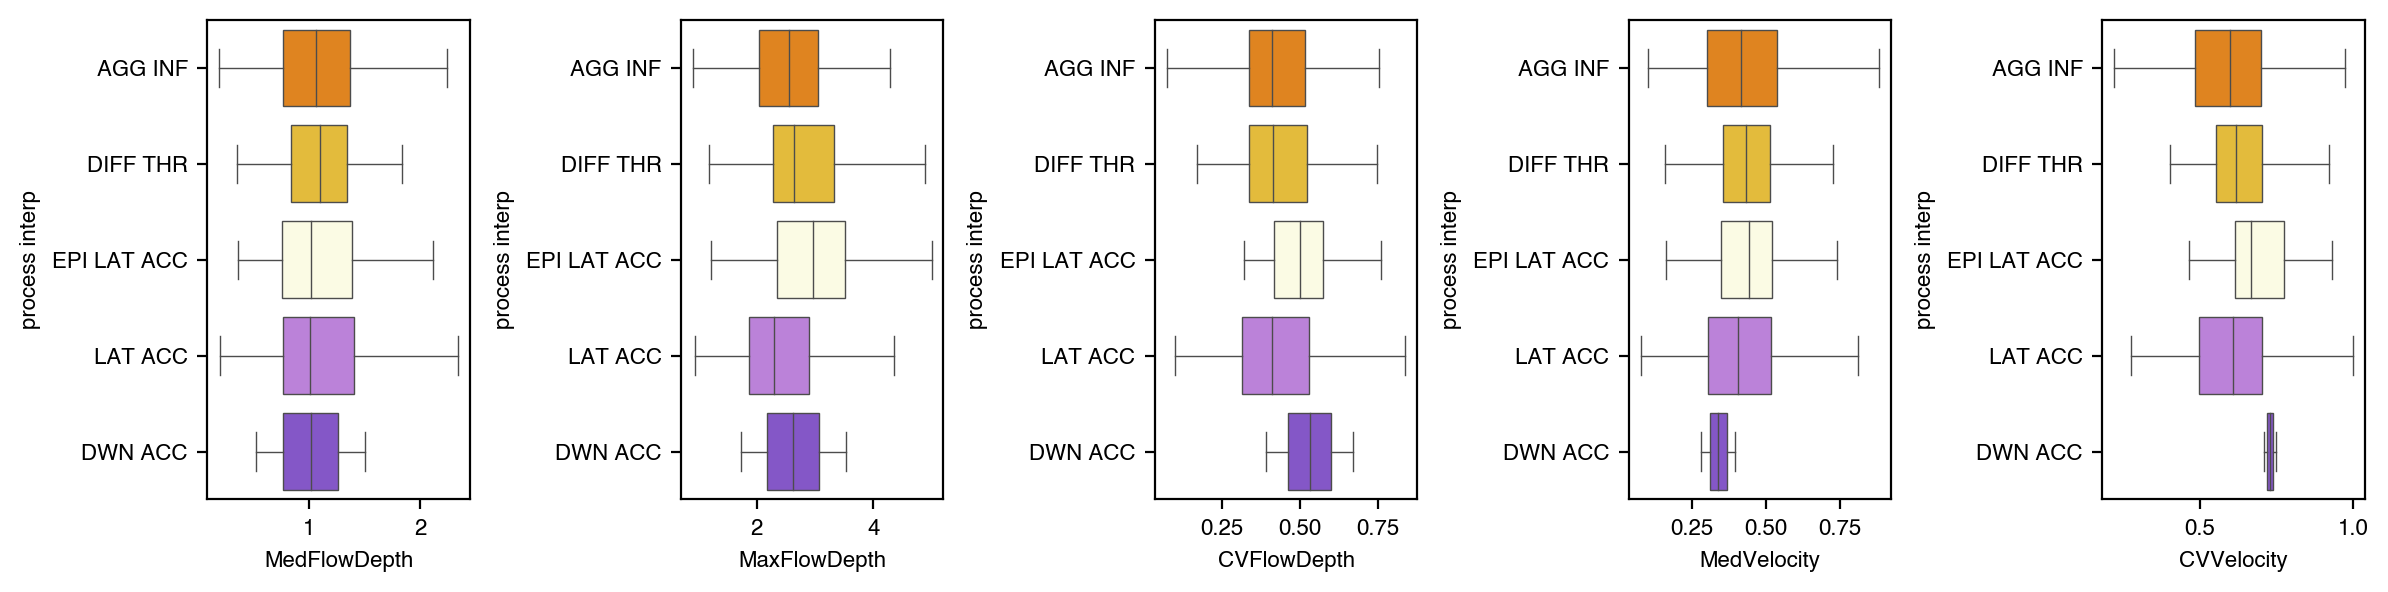

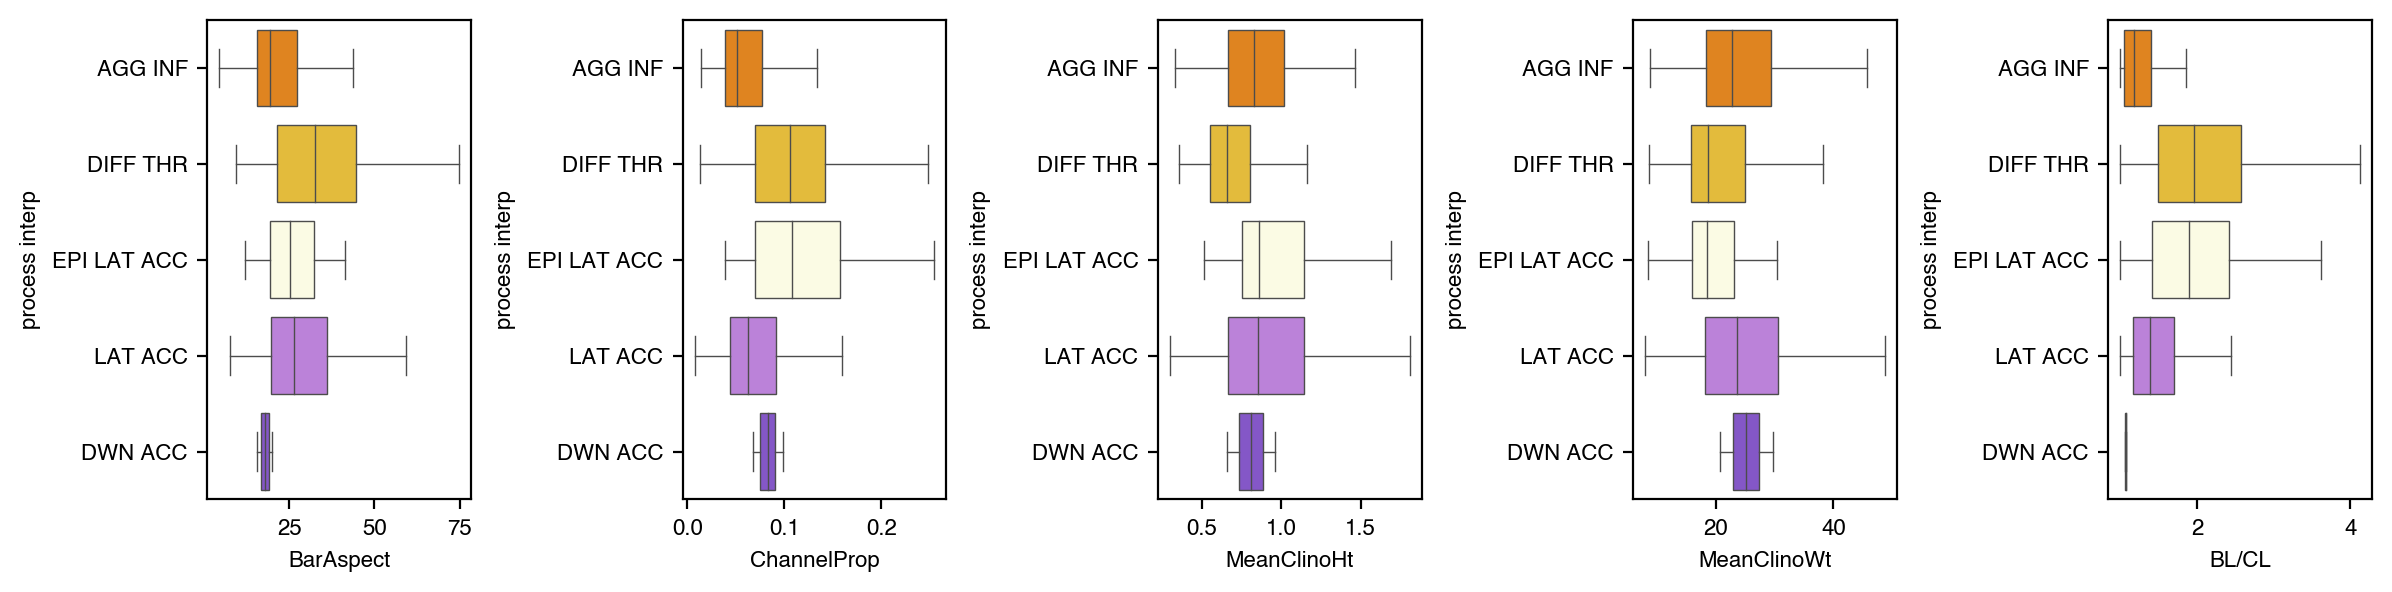

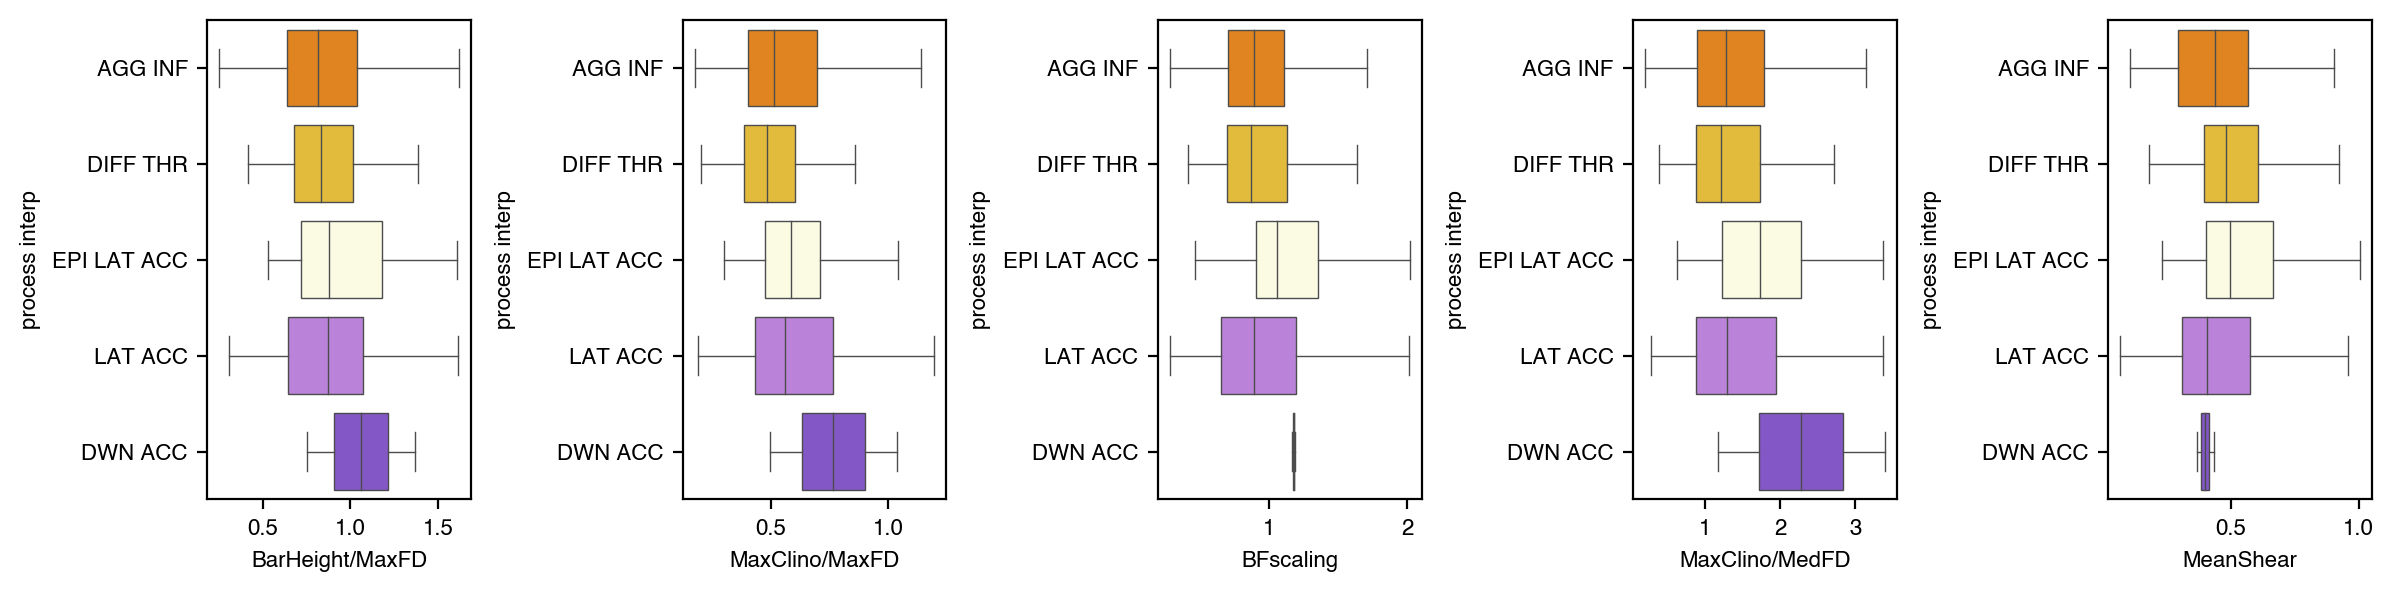

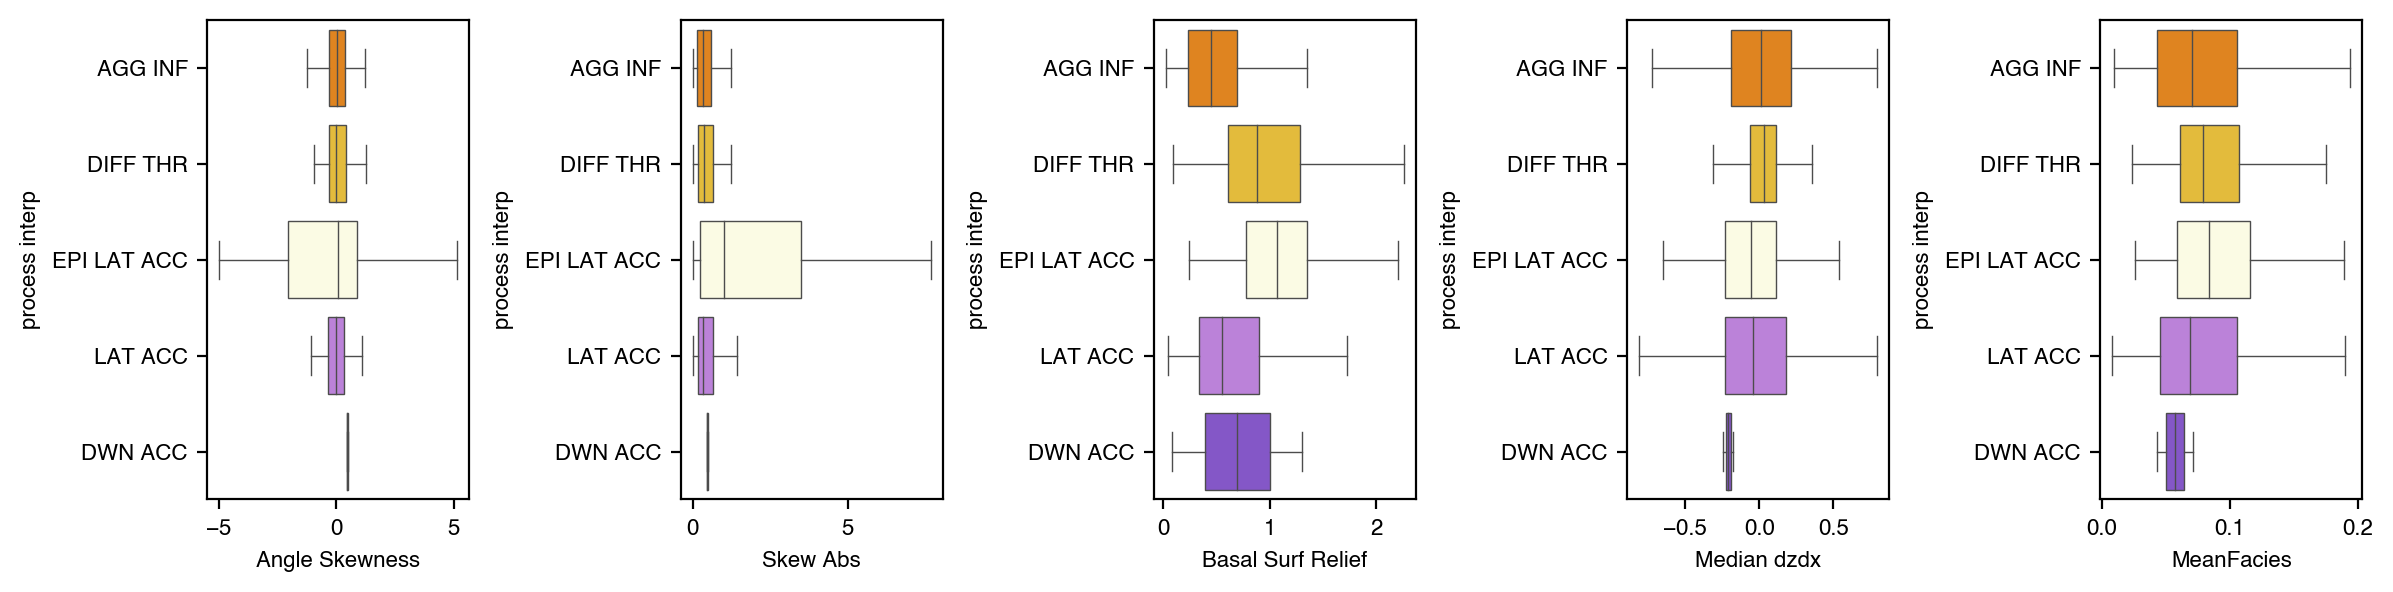

In [38]:

fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (12, 3), dpi = 200, tight_layout = True)
# plt.xticks(rotation=45)

ax = ax.ravel()
for i, a in enumerate(ax):
    # plt.xticks(rotation=45)
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = hydraulic_vars[i], palette = proc_palette, ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], y = 'process interp', x = hydraulic_vars[i],  palette = proc_palette, ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    # plt.xticks(rotation=45)

    
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (12, 3), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = geometric_vars[i], palette = proc_palette, ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], y = 'process interp', x = geometric_vars[i],  palette = proc_palette, ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(scalers), figsize = (12, 3), dpi = 200, tight_layout = True)
ax[3].set_ylim(-1, 10)
ax[2].set_ylim(-1, 10)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = scalers[i], palette = proc_palette, ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], y = 'process interp', x = scalers[i],  palette = proc_palette, ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    
# fig, ax = plt.subplots(1, len(scalers), figsize = (10, 3), dpi = 200, tight_layout = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], hue = 'BinFacMean', ax = a, split = True)
fig, ax = plt.subplots(1, len(diagnostics), figsize = (12, 3), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = geometric_vars[i], palette = proc_palette, ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], y = 'process interp', x = diagnostics[i],  palette = proc_palette, ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    

Find the percentage of upper and lower bar facies for each bar

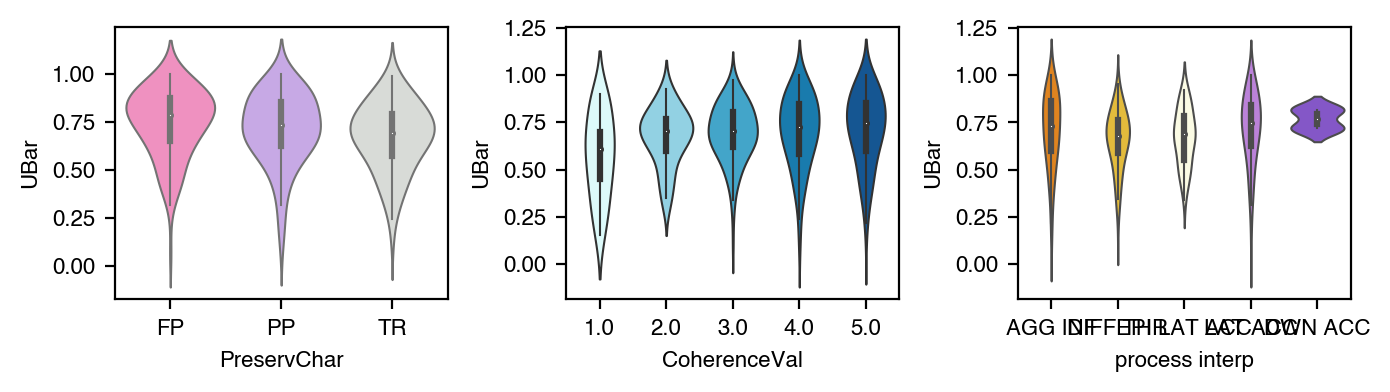

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (7, 2), dpi = 200, tight_layout=True)
sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = 'UBar', palette = pres_palette, linewidth = 0.75, bw = .5, ax = ax[0]);
sns.violinplot(data = allbars[allbars['StartTime']>eqt].sort_values(by=['CoherenceVal'], ascending = True), x = 'CoherenceVal', y = 'UBar', palette = coh_palette, linewidth = 0.75, bw = 0.5, alpha = 0.4, ax = ax[1])
sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = 'UBar', palette = proc_palette, linewidth = 0.75, bw = .5, ax = ax[2]);


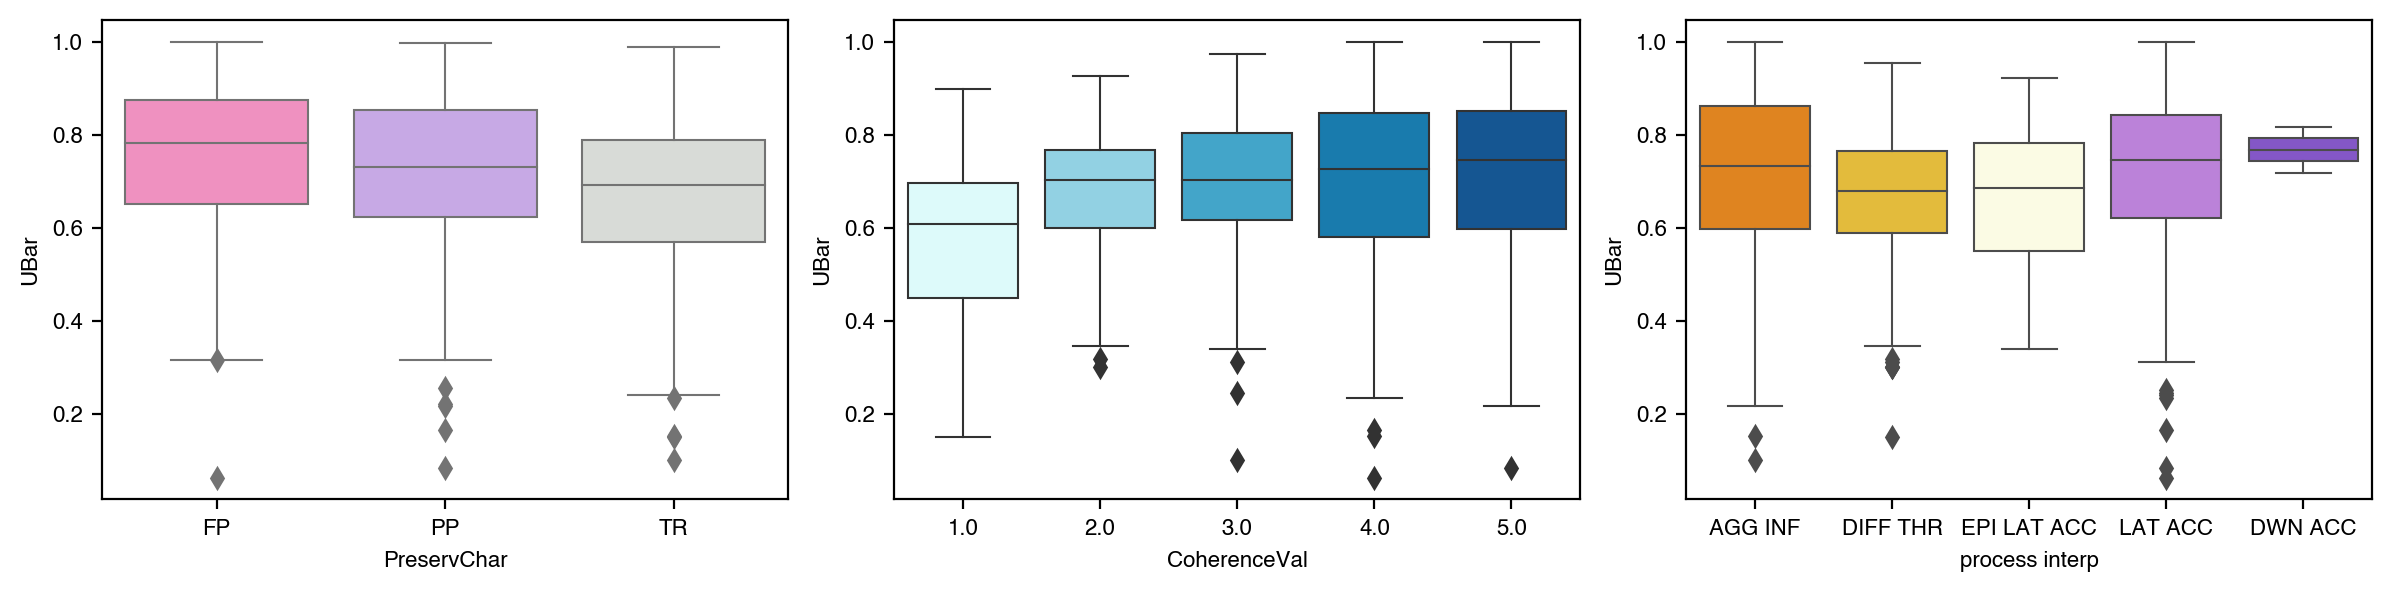

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, tight_layout=True)
sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = 'UBar', palette = pres_palette, linewidth = 0.75, showfliers = True, ax = ax[0]);
sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'CoherenceVal', y = 'UBar', palette = coh_palette, linewidth = 0.75, showfliers = True, ax = ax[1])
sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'process interp', y = 'UBar', palette = proc_palette, linewidth = 0.75, showfliers = True, ax = ax[2]);


Testing BL/CL ratio from Heller Braided

Text(0.5, 0.98, 'BL/CL Ratio from Heller et al. Manuscript')

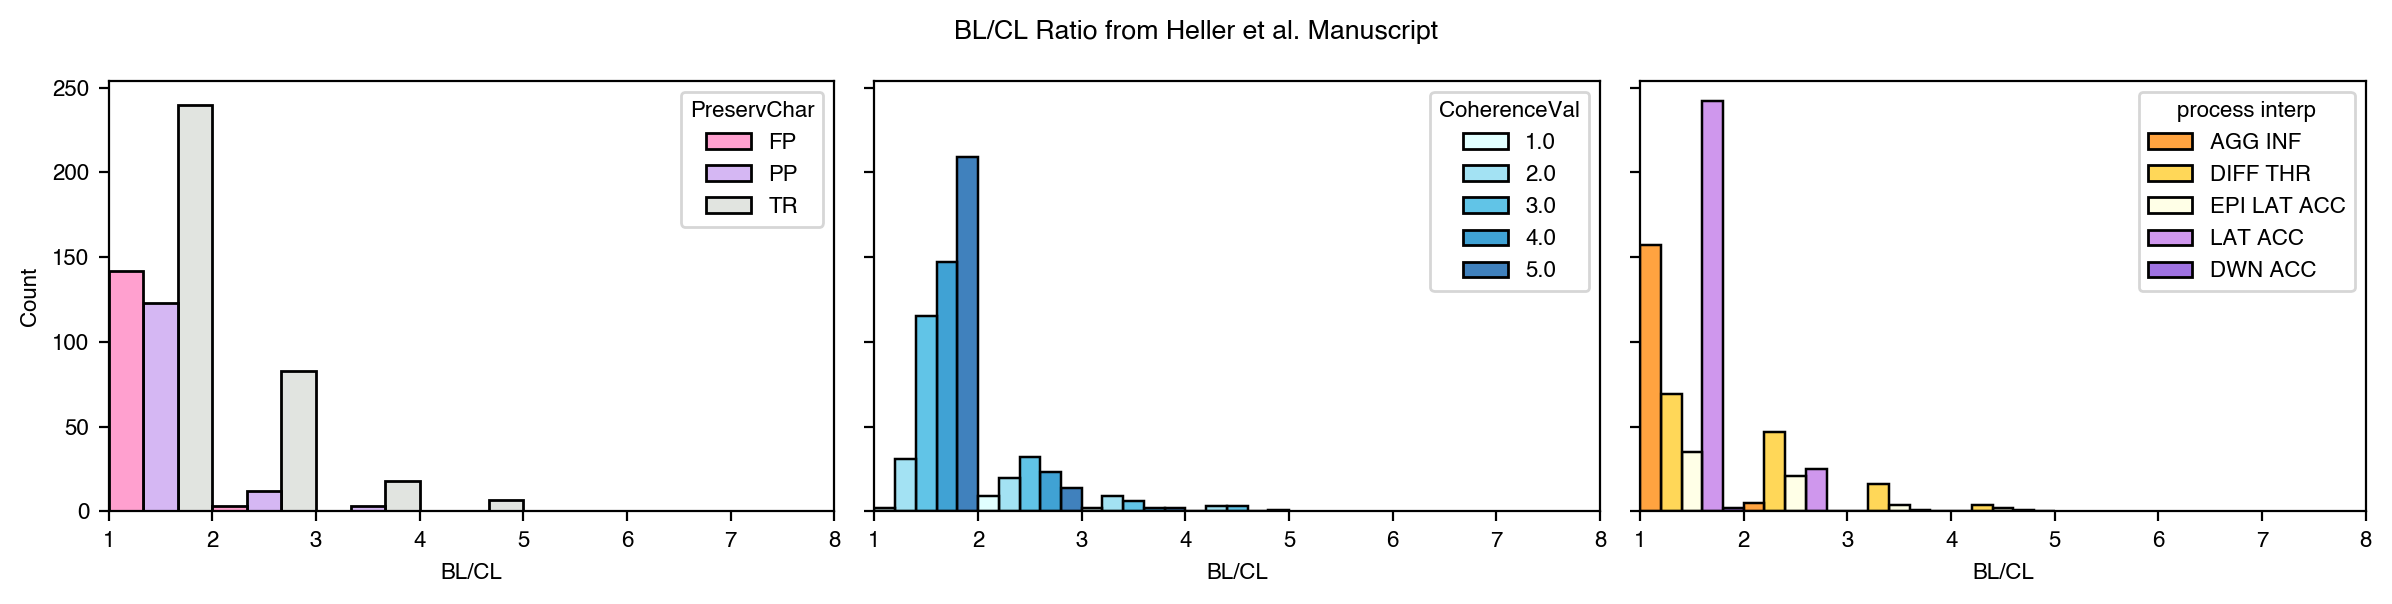

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, sharey = True, tight_layout = True, sharex = True)
sns.histplot(data = allbars[allbars['StartTime']>eqt], x = 'BL/CL', hue = 'PreservChar', palette = pres_palette, ax = ax[0], multiple = 'dodge', binwidth = 1)
sns.histplot(data = allbars[allbars['StartTime']>eqt], x = 'BL/CL', hue = 'CoherenceVal', palette = coh_palette, ax = ax[1], multiple = 'dodge', binwidth = 1)
sns.histplot(data = allbars[allbars['StartTime']>eqt], x = 'BL/CL', hue = 'process interp', palette = proc_palette, ax = ax[2], multiple = 'dodge', binwidth = 1)
ax[0].set_xlim(1, 8)
fig.suptitle('BL/CL Ratio from Heller et al. Manuscript')

### Testing hypotheses from candidacy propsal:
1. Increased preservation in zones where the channel is widening
2. Wider, thinner packages at zones of thread splitting
3. More relief at zones where channel belt is widening

In [43]:
avg_wr = np.average(total_wr_2h, axis = 1)
# avg_wr = np.concatenate((np.arange(0, len(avg_wr)), avg_wr), axis = 1)
wideningzones = np.where(avg_wr>np.quantile(avg_wr, 0.75))
wideningzones= wideningzones[0]
widening10 = np.unique(np.round(wideningzones, -1))

Text(0.5, 1.0, 'average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

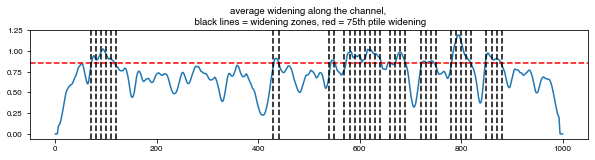

In [44]:
plt.figure(figsize = (10, 2))
plt.plot(avg_wr)
plt.axhline(np.quantile(avg_wr, 0.75), c = 'r', ls = '--')
for i in widening10:
    plt.axvline(i, c = 'k', ls = '--')
    
plt.title('average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

In [46]:
wideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = wideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is False:
        wideningbars = wideningbars.drop([row])

notwideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = notwideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is True:
        notwideningbars = notwideningbars.drop([row])

    
# df.drop(df[(df.score < 50) & (df.score > 20)].index)

Text(0.5, 1.0, '<75th p Widening')

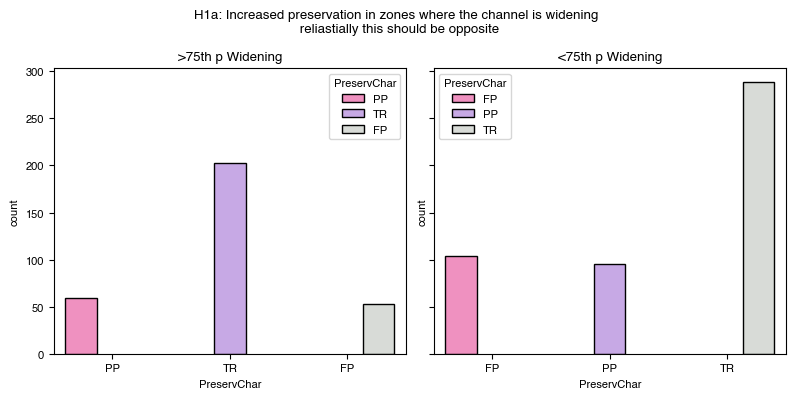

In [132]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi = 100)
sns.countplot(x = 'PreservChar', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0], edgecolor = 'k')
sns.countplot(x = 'PreservChar', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1], edgecolor = 'k')
fig.suptitle('H1a: Increased preservation in zones where the channel is widening \n reliastially this should be opposite')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

Text(0.5, 1.0, '<75th p Widening')

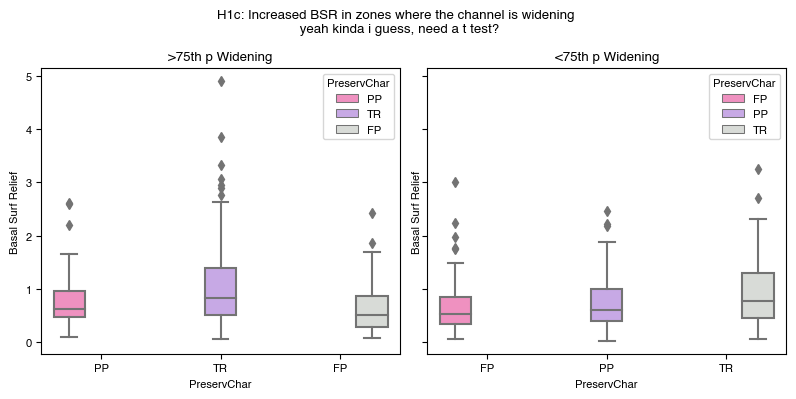

In [130]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi= 100)
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0], edgecolor = 'k')
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1], edgecolor = 'k')
fig.suptitle('H1c: Increased BSR in zones where the channel is widening \n yeah kinda i guess, need a t test?')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

### Proportion plot, make sure sort is FP, PP, TR

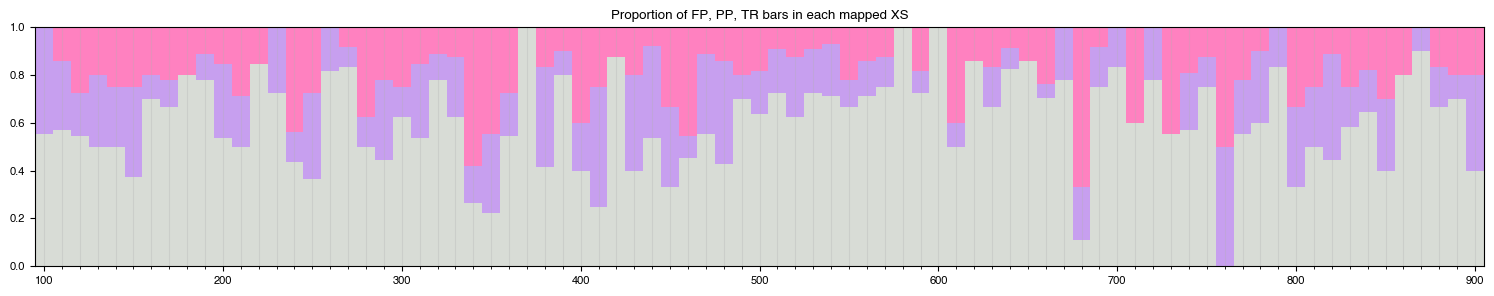

In [404]:
activech_mode = stats.mode(active_channels, axis = 1)[0]
pres_frequencies = np.empty([4, len(np.unique(allbars['iloc']))])
pres_frequencies[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 10

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    totalbars = len(subsample)
    pres_frequencies[1, idx] = len(subsample[subsample['PreservChar']=='FP'])/totalbars
    pres_frequencies[2, idx] = len(subsample[subsample['PreservChar']=='PP'])/totalbars
    pres_frequencies[3, idx] = len(subsample[subsample['PreservChar']=='TR'])/totalbars

    plt.bar(i, pres_frequencies[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_frequencies[2, idx], w, bottom = pres_frequencies[3, idx], color = pres_cols[1])
    plt.bar(i, pres_frequencies[1, idx], w, bottom = np.sum(pres_frequencies[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.3)
# plt.xlabel('Streamwise distance, m')
# plt.ylabel('Bar proportion')

# ax = plt.gca()
# ax1 = ax.twinx()
# # ax1.plot(avg_wr, 'k-')
# # ax1.axhline(np.quantile(avg_wr, 0.5), c = 'k', ls = '--', alpha = 0.5)
# # ax1.set_ylabel('Average widening rate')

# ax1.fill_between(np.arange(0, len(active_channels)), active_channels.min(axis = 1), active_channels.max(axis = 1), alpha = 0.1, color = 'k')
# plt.plot(activech_mode, 'k-')
# # plt.fill_between(np.arange(0, len(total_wr_2h))*10, total_wr_2h.min(axis = 1), total_wr_2h.max(axis = 1), alpha = 0.1, color = 'k')

In [415]:
subsample.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'PresNum',
       'CoherenceVal', 'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge',
       'RightEdge', 'BarWidth', 'BarHeight', 'BarAspect', 'BarArea',
       'Section Area', 'ChannelProp', 'Angle Skewness', 'Basal Surf Relief',
       'Mean dzdx', 'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt',
       'MeanClinoHt', 'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt',
       'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD',
       'MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD',
       'MedClinoICD', 'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth',
       'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear',
       'ModeShear', 'MeanShear', 'SDShear', 'MedShear', 'MinVelocity',
       'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity',
       'MedVelocity', 'process interp', 'CVFlowDepth', 'CVVelocity',
       'Skew Abs', 'TempAgg', 'Skew Binned', 'Co Binne

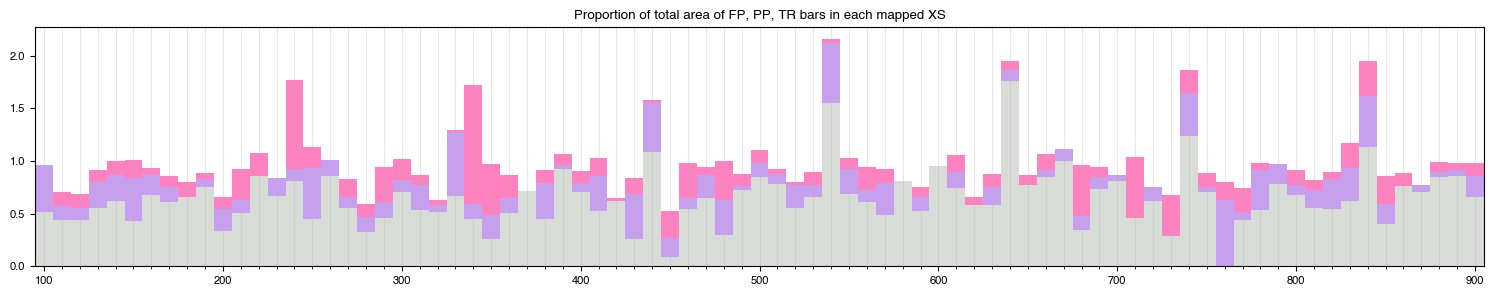

In [416]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 10

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])#/chanarea
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])#/chanarea
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])#/chanarea

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.3)

<AxesSubplot:xlabel='StartTime', ylabel='BarArea'>

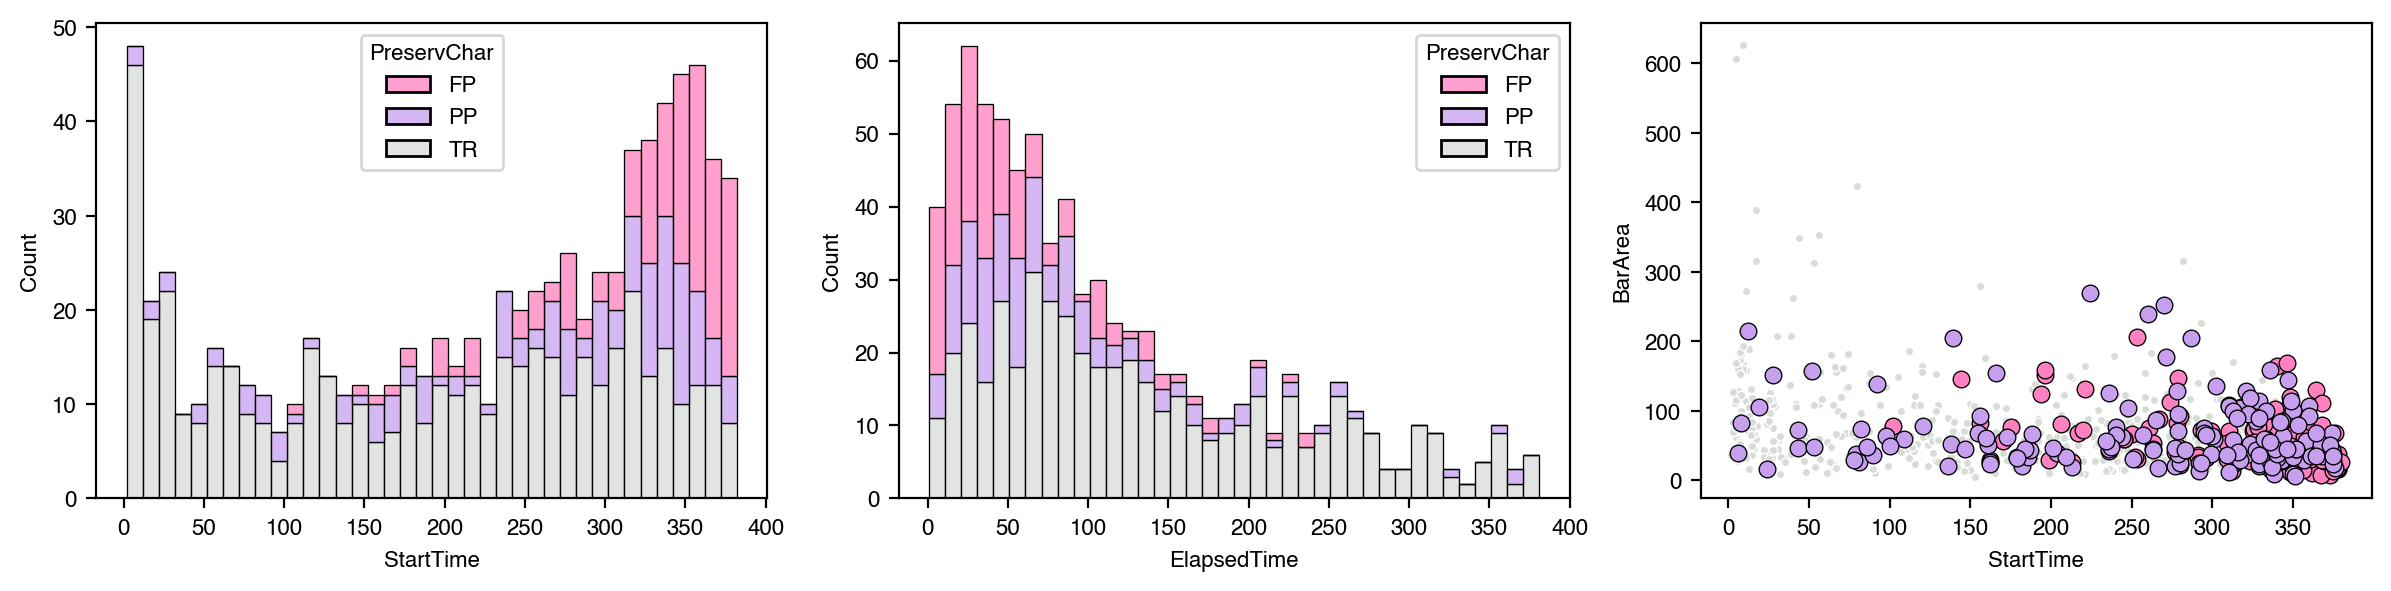

In [364]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, tight_layout = True)
sns.histplot(x = 'StartTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'stack', ax = ax[0], binwidth = 10)
sns.histplot(x = 'ElapsedTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'stack', ax = ax[1], binwidth = 10)
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='TR'], ax = ax[2], c = ['xkcd:light grey'], marker = '.')
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='FP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:pink'])
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='PP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:lavender'])



### Box plots again, but of threadiness and widening

In [305]:
active_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
threaddf = pd.DataFrame(active_channels.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
threaddf_mapped = deepcopy(threaddf.iloc[:, ::10]).iloc[:, 10:90]

In [323]:
# wetwid_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
wetwidthdf = pd.DataFrame(wetted_width.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
wetwidthdf_mapped = deepcopy(wetwidthdf.iloc[:, ::10]).iloc[:, 10:90]

Text(0.5, 1.0, 'Wetted width')

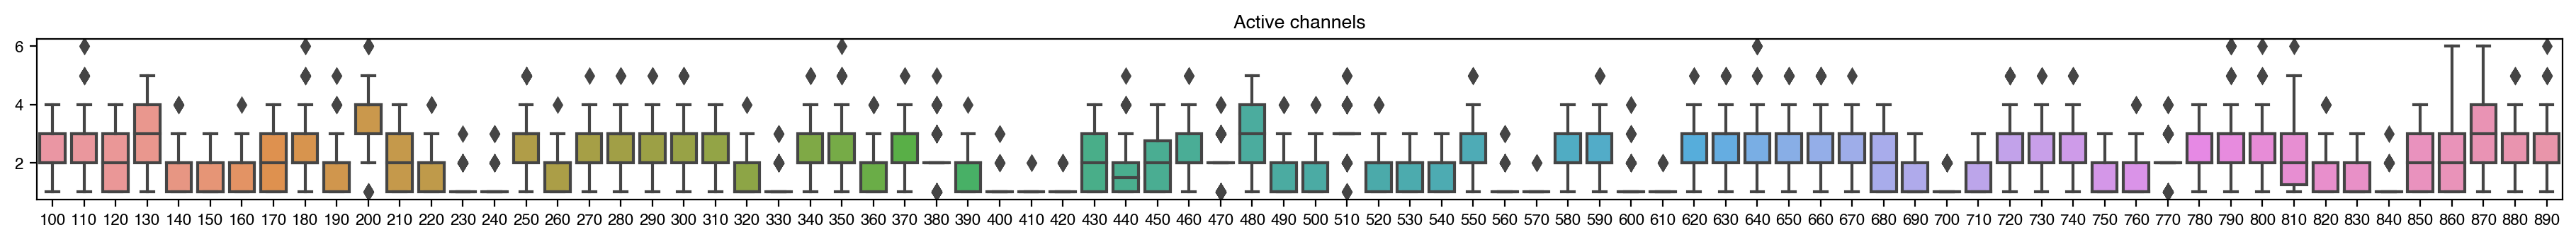

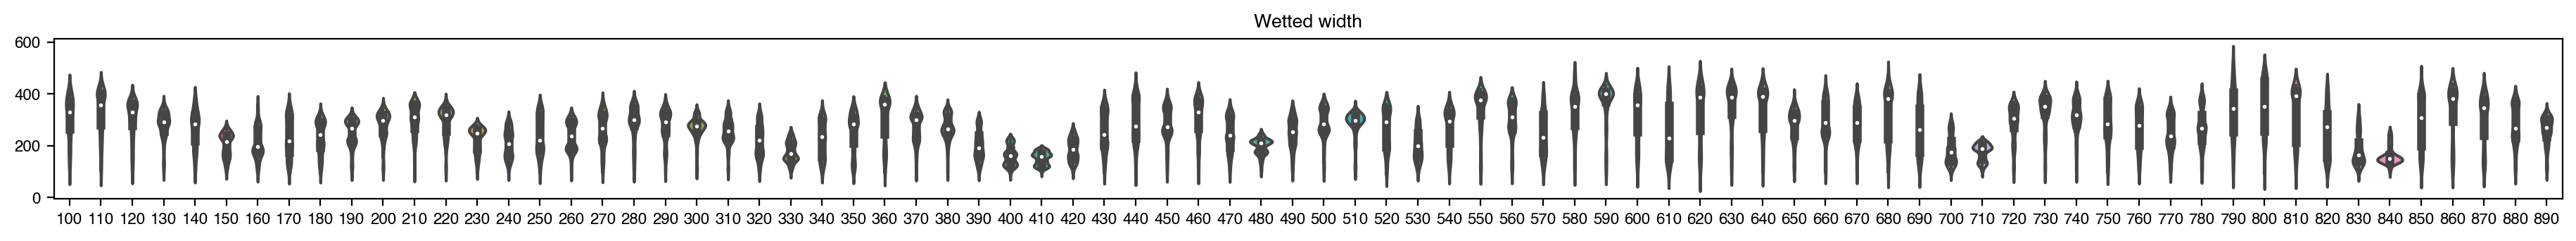

In [326]:
plt.figure(figsize = (23, 1.5), dpi = 200)
sns.boxplot(data = threaddf_mapped)
plt.title('Active channels')
plt.figure(figsize = (23, 1.5), dpi = 200)
sns.violinplot(data = wetwidthdf_mapped)
plt.title('Wetted width')

In [376]:
### define timestep after which the channel width kinda stabilises (after spin up time)
equilts2 = 60 ## 2 hour data
equilts10 = 12 ## 10 hour data

In [395]:
# Turn widening rates into dataframes so you can make boxplots
wide10df = pd.DataFrame(total_wr.T)
wide10df_mapped = deepcopy(wide10df.iloc[:, ::10]).iloc[:, 10:90] 

wide2df = pd.DataFrame(total_wr_2h.T)
wide2df_mapped = deepcopy(wide2df.iloc[:, ::10]).iloc[:, 10:90]

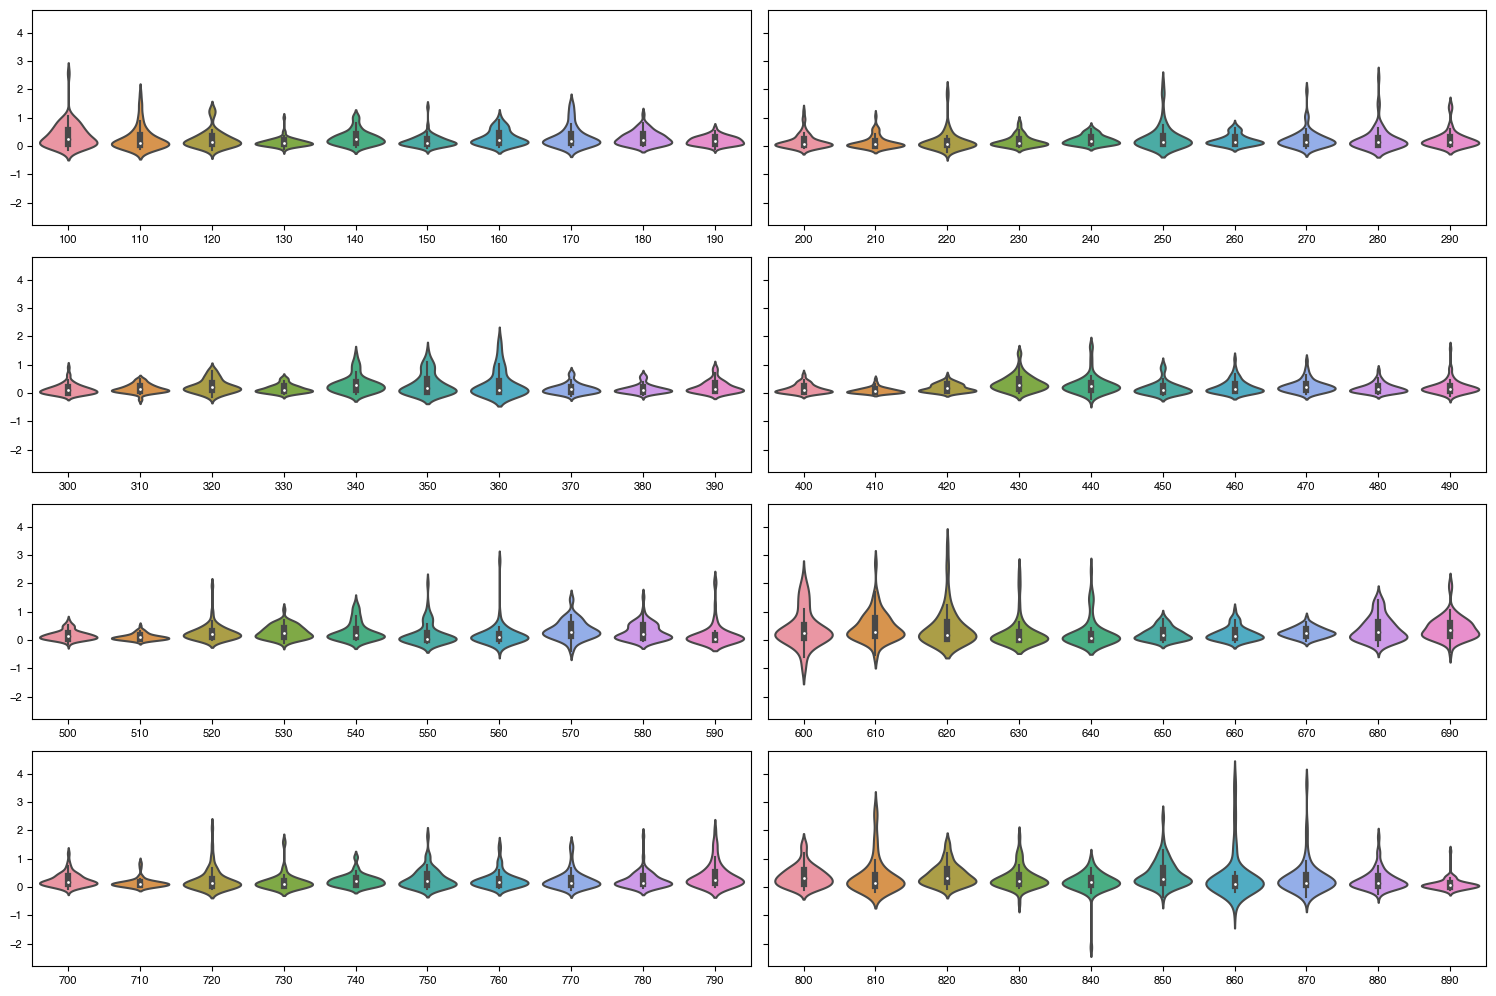

In [388]:
fig, ax = plt.subplots(4, 2, tight_layout = True, sharey = True, dpi = 100, figsize = (15, 10))
ax = ax.ravel()

for i, a in enumerate(ax):
    sns.violinplot(data = wide10df_mapped.iloc[equilts10:, i*10:i*10+10], ax = a, scale = 'count')


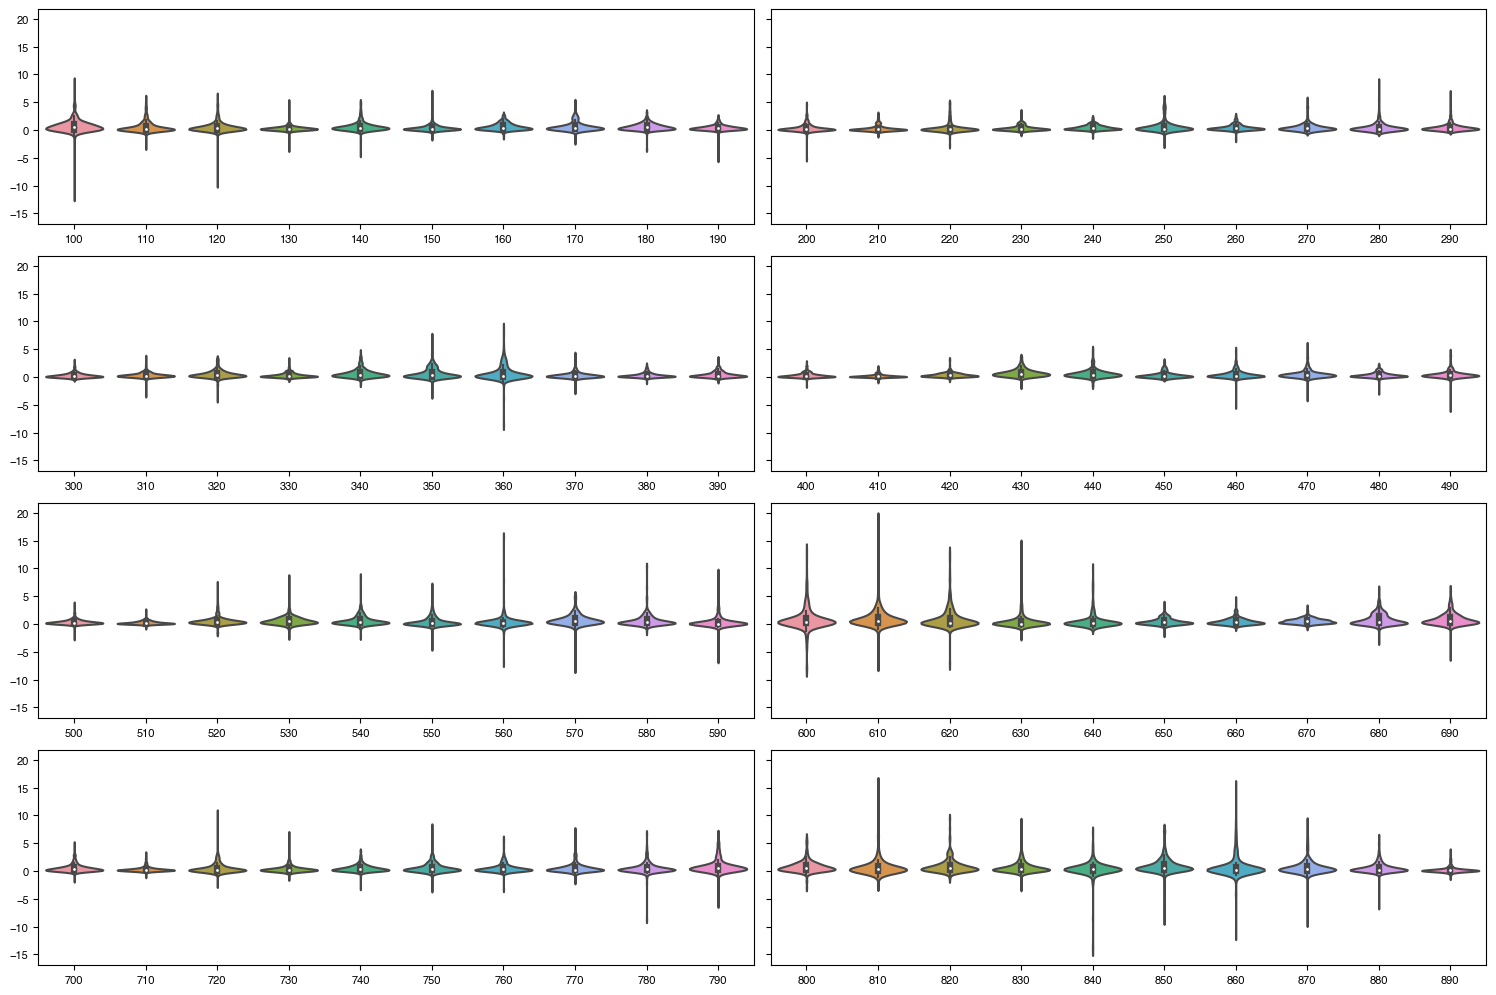

In [397]:
fig, ax = plt.subplots(4, 2, tight_layout = True, sharey = True, dpi = 100, figsize = (15, 10))
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.violinplot(data = wide2df_mapped.iloc[equilts2:, i*10:i*10+10], ax = a, scale = 'count', inner = 'box')
    


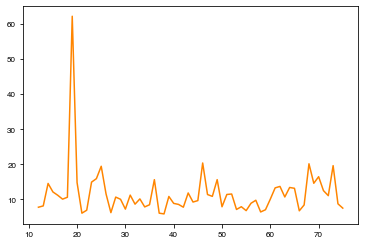

In [400]:
# plt.plot(wide2df_mapped.iloc[equilts2:, :].max(axis=1)/np.median(wide2df_mapped.iloc[equilts2:, :], axis=1))
plt.plot(wide10df_mapped.iloc[equilts10:, :].max(axis=1)/np.median(wide10df_mapped.iloc[equilts10:, :], axis=1))

In [391]:
wide2df_mapped.iloc[equilts2:, :].shape

(16, 80)

In [394]:
wide10df_mapped.shape

(76, 80)